# Compute correlations in longitude bins with no regime averaging

In [1]:
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [3]:
client = Client(threads_per_worker = 1)

## Part 1, importing U_along and binning in 10 degree bins

In [4]:
#importing the daily ualong
u_along_unbinned_fine = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/*')


In [5]:
#volume timeseries
volume_percentage = xr.open_dataset('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/percentage_of_CDW.nc')



In [6]:
def binning_age_3deg(CSHT_along, age_sigma, vol_sigma, CSHT_for_3degbinning):
    
    #binning into 3deg
    bin_width = 3
    bin_spacing = 0.25
    lon_west = -280
    lon_east = 80
    
    # new coordinate and midpoints of longitude bins:
    full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
    lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
    
    n_bin_edges = len(full_lon_coord)
    lon_along_contour = np.array(CSHT_along.lon_along_contour)
    lat_along_contour = np.array(CSHT_along.lat_along_contour)
    
    
    bin_edge_indices = np.zeros(n_bin_edges)
    for lon_bin in range(n_bin_edges-1):
        # find first isobath point that has the right longitude:
        first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
        # then find all other isobath points with the same longitude as that first point:
        same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
        # we want the most southerly of these points on the same longitude line:
        bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
        
    # define east/west edges:
    bin_edge_indices = bin_edge_indices.astype(int)
    bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
    bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
    n_bins = len(bin_edge_indices_west)
    
    
    lat_bin_midpoints = np.zeros(n_bins)
    for lon_bin in range(n_bins):
        # find nearest isobath point:
        lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
        lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
    
    
    #averaging the age along the contour, in sigma bins
    age_sigma = age_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    
    age_contour_3deg = np.zeros([age_sigma.shape[0],108,n_bins])*np.nan
    for lon_bin in range(n_bins):
        age_contour_3deg0 = age_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        distance_along0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        #making sure we only have distances where there are values
        distance_along0 = ((age_contour_3deg0 *0)+1) *distance_along0
        age_contour_3deg[:,:,lon_bin] = (np.nansum(age_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))
    
    #removing zeros
    age_contour_3degnp = np.where(age_contour_3deg!=0,age_contour_3deg,np.nan)
    
    
    #ages
    age_contour_3deg = CSHT_for_3degbinning.binned_cross_slope_heat_trans.copy()
    age_contour_3deg.name = 'age'
    age_contour_3deg.values = age_contour_3degnp
    
    vol_sigma = vol_sigma.transpose('time','sigma_bin','contour_index') #making sure the dimensions are correctly aligned for indexing
    
    vol_contour_3deg = np.zeros([age_sigma.shape[0],108,n_bins])*np.nan
    for lon_bin in range(n_bins):
        vol_contour_3deg0 = vol_sigma[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        vol_contour_3deg[:,:,lon_bin] = (np.nansum(vol_contour_3deg0,axis=2))
    
    #removing zeros
    vol_contour_3degnp = np.where(vol_contour_3deg!=0,vol_contour_3deg,np.nan)
    
    #volumes_rho
    vol_contour_3deg = CSHT_for_3degbinning.binned_cross_slope_heat_trans.copy()
    vol_contour_3deg.name = 'Volume'
    vol_contour_3deg.values = vol_contour_3degnp
    
    
    return age_contour_3deg, vol_contour_3deg

In [7]:
Volume_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/volume_daily_10deg/OM2_01_iaf_cycle3/VOL*.nc')

## Load u_along and CSHT if you want to compute correlations from scratch:
Note if these are already calculated, there is section below that opens the already saved correlations and analyses them.

In [8]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')
u_along_daily = xr.open_dataset('/g/data/ik11/users/wf4500/ASC_project_files/DailyU_climatology_rho_10deg_bins.nc')

# resample monthly: - not needed here
u_along_da_months = u_along.resample(time='1M').mean()#.U_along_contour_binned
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))#.rename({'lon_bin_midpoints': 'lon'})
u_along_da_months.load();

In [9]:
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})
CSHT_along_noZC = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})
#/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc
#/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc
# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_along_monthly_noZC = CSHT_along_noZC.resample(time='1M').mean()

In [10]:
# monthly water mass mask 
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

In [11]:
daily_age_mask = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/*.nc')


In [12]:
CSHT_daily_along_CDW = CSHT_along*daily_age_mask.CDW_mask
u_daily_along_CDW = u_along_daily*daily_age_mask.CDW_mask
CSHT_daily_along_AASW = CSHT_along*daily_age_mask.AASW_mask
u_daily_along_AASW = u_along_daily*daily_age_mask.AASW_mask

In [13]:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')

In [14]:
vol_bins 

<xarray.Dataset> Size: 23MB
Dimensions:   (potrho0: 108, time: 732, lon_bins: 36)
Coordinates:
  * potrho0   (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    volume    (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>

### Do different time averaging to compute correlations on different time scales - daily in this notebook only

In [15]:
n_bins = len(vol_bins.lon_bins)

In [16]:
# def vol_ave_potrho0_potmask(mask, quantity,vol_bins):
#     return (mask * quantity * vol_bins.volume).mean('potrho0')/(mask*vol_bins).mean('potrho0').volume

In [17]:
def vol_ave_potrho0_potmask(mask, quantity,vol_bins):
    return (mask * quantity * vol_bins.volume).sum('potrho0')/(mask*vol_bins).sum('potrho0').volume

# Climatology

In [18]:
# interpolate monthly volume bins to daily and get a climatology
vol_daily_interp = vol_bins.resample(time="1D").interpolate("linear")
#vol_daily_interp_noleap = vol_daily_interp.convert_calendar('noleap')
vol_daily_interp_noleap = Volume_daily.Volume.convert_calendar('noleap')
vol_bins_daily_clim = vol_daily_interp_noleap.groupby('time.dayofyear').mean(dim = 'time')

In [19]:
# ## use daily climatology volume bins for simplicity + so we dont have to save daily changes
# U_along_binned_CDW_daily =  vol_ave_potrho0_potmask(daily_age_mask.CDW_mask ,u_along_daily,vol_bins_daily_clim).load()
# U_along_binned_AASW_daily =  vol_ave_potrho0_potmask(daily_age_mask.AASW_mask ,u_along_daily,vol_bins_daily_clim).load()

## can skip -- plots to check the missing values, rectified now

In [20]:
# ((age_mask.CDW_mask*u_along*vol_bins.volume).mean('potrho0')\
#  /(age_mask.CDW_mask*vol_bins).mean('potrho0').volume).U.plot(vmax = 0.5, vmin = -0.5, cmap = 'RdBu')
# ## monthly ASC speed av in CDW layer. 

In [21]:
# ((daily_age_mask.AASW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume).ASCspeed.plot()
# plt.title('AASW')
# plt.figure()
# ((daily_age_mask.DSW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume).ASCspeed.plot(label = 'DSW ASC speed')
# plt.title('DSW')

In [22]:
# ## missing times in ASC speed in CDW layer
# #u_along_daily
# ((daily_age_mask.CDW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')\
#  /(daily_age_mask.CDW_mask*vol_bins_daily_clim).mean('potrho0').volume)\
#     .ASCspeed.plot(vmax = 0.1, vmin = -0.1, cmap = 'RdBu_r')

In [23]:
asc_cdw_av_clim = ((daily_age_mask.CDW_mask*u_along_daily* vol_bins_daily_clim).mean('potrho0')\
                   /vol_bins_daily_clim.mean('potrho0'))


In [24]:
mean_CDW_ASC =((daily_age_mask.CDW_mask*u_along_daily* vol_bins_daily_clim).mean('potrho0')/vol_bins_daily_clim.mean('potrho0'))

In [25]:
# ## missing times in ASC speed in CDW layer
# ((daily_age_mask.CDW_mask*CSHT_along.groupby('time.dayofyear').mean('time')* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume).CSHT_ZC_lon_binned.plot()

## return to CDW/AASW correlations

In [26]:
CSHT_binned_CDW_daily =  (daily_age_mask.CDW_mask *CSHT_along.groupby('time.dayofyear').mean('time'))#.sum('potrho0').load()
CSHT_binned_AASW_daily = (daily_age_mask.AASW_mask *CSHT_along.groupby('time.dayofyear').mean('time'))#.sum('potrho0').load()

In [27]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Based on the above, turns out we need to interpolate the volume bins, or else there are days in the climatology with no CDW mass, which is what we wanted to avoid in the first place?

In [28]:
def daily_clima(u_along, CSHT_along):
    u_along_da_clima = u_along#.U_along_contour_binned).sel(potrho0=slice(13.8,28.42)).rename({'lon_bin_midpoints': 'lon'})
    U_along_clima_binned = u_along_da_clima#.mean('dayofyear') #.groupby('time.dayofyear')
    #U_along_clima_binned.load();
    
    CSHT_clima = CSHT_along#((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*scaling_factor).rename({'lon_bin_midpoints':'lon'})
    CSHT_clima_binned = CSHT_clima#.mean('dayofyear') #.sel(potrho0=slice(13.8,28.42)).groupby('time.dayofyear')
    #CSHT_clima_binned = CSHT_clima_binned.load()
    return U_along_clima_binned, CSHT_clima_binned.sum('potrho0')

In [29]:
# U_along_binned_CDW_daily_clima, CSHT_binned_CDW_daily_clima = daily_clima(U_along_binned_CDW_daily, CSHT_binned_CDW_daily)

In [30]:
# U_along_binned_AASW_daily_clima, CSHT_binned_AASW_daily_clima = daily_clima(U_along_binned_AASW_daily, CSHT_binned_AASW_daily)

### Now compute the correlations:

In [31]:
files_path = '/g/data/e14/qo9901/ASC_collab_CSHT_ds/'

In [32]:
def water_mass_daily(U_along_daily_binned,  CSHT_daily_binned):
        
    len_lonbin = len(U_along_daily_binned.lon_bins) # 10deg bins

    slope_daily = np.zeros(( len_lonbin))
    stderr_daily = np.zeros((len_lonbin))
    r_sq_daily = np.zeros((len_lonbin))
    
    for i in range(len_lonbin):

        slope_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).slope
        stderr_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).stderr
        r_sq_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).rvalue**2

    return slope_daily, stderr_daily, r_sq_daily

In [33]:
CSHT_annual_withZC = (CSHT_along.CSHT_ZC_lon_binned.resample(time='1M').mean() *age_mask.CDW_mask).sum('potrho0').resample(time='1Y').mean().mean('time').sum().compute()

In [34]:
CSHT_along_annual_noZC = (CSHT_along_monthly_noZC.CSHT_lon_binned * age_mask.CDW_mask).resample(time='1m').mean().sum('potrho0').resample(time='1y').mean()
u_along_annual = (u_along_da_months.U * age_mask.CDW_mask).weighted((age_mask.CDW_mask*vol_bins.volume).fillna(0)).mean('potrho0').resample(time='1y').mean()
CSHT_along_annual_noZC.load()
u_along_annual.load()
print('loaded data')

loaded data


In [35]:
factor = CSHT_annual_withZC/ CSHT_along_annual_noZC.mean('time').sum()
CSHT_along_annual_noZC = factor*CSHT_along_annual_noZC

In [36]:
slope_annual_noZC, stderr_annual_noZC, r_sq_annual_noZC = water_mass_daily(u_along_annual,\
                                                                            CSHT_along_annual_noZC) 

In [37]:
file_extension = 'agemaskCDW_daily'
coordinatesBin=dict(lon_bins=(['lon_bins'], u_along_annual.lon_bins.data))

slope_annual_xr_noZC = xr.DataArray(slope_annual_noZC, coords = coordinatesBin, dims = ['lon_bins'])
stderr_annual_xr_noZC = xr.DataArray(stderr_annual_noZC, coords = coordinatesBin, dims = ['lon_bins'])
r_sq_annual_xr_noZC = xr.DataArray(r_sq_annual_noZC, coords = coordinatesBin, dims = ['lon_bins'])
slope_annual_xr_noZC.name = 'slope_clima'
stderr_annual_xr_noZC.name = 'stderr_clima'
r_sq_annual_xr_noZC.name = 'r_sq_clim'


In [38]:
# slope_daily, stderr_daily, r_sq_daily = water_mass_daily(U_along_binned_AASW_daily_clima.ASCspeed,  CSHT_binned_AASW_daily_clima.CSHT_ZC_lon_binned) 

In [39]:
# file_extension = 'agemaskAASW_daily'
# coordinatesBin=dict(lon_bins=(['lon_bins'], U_along_binned_AASW_daily_clima.lon_bins.data))

# slope_clima_xr = xr.DataArray(slope_daily, coords = coordinatesBin, dims = ['lon_bins'])
# stderr_clima_xr = xr.DataArray(stderr_daily, coords = coordinatesBin, dims = ['lon_bins'])
# r_sq_clima_xr = xr.DataArray(r_sq_daily, coords = coordinatesBin, dims = ['lon_bins'])
# slope_clima_xr.name = 'slope_clima'
# stderr_clima_xr.name = 'stderr_clima'
# r_sq_clima_xr.name = 'r_sq_clim'

## Reopen correlations previously saved above:

## to move colorbar lower and add arrows to show the meaning of the slkop and the direction
make the middle white color cream so it actually looks like a continuos line and not 
** or ==background color==
** OR outline
** monthly panel on the top
** make additional version with the regime bar on the top

In [40]:
# del r_sq_daily_10deg_noZC,slope_sq_daily_10deg_noZC 

In [41]:
files_path = '/g/data/ik11/users/wf4500/ASC_project_files/' # 10deg
file_extension = 'agemaskCDW_volav'
file_extension_daily_clima = 'agemaskCDW_daily'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '_corr.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '_corr.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()

# ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension + '_APR10.nc')
# r_sq_clima_10deg = ds.r_sq_clim
# ds.close()

ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
r_sq_daily_10deg = ds.r_sq_clim
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10_noZC.nc')
r_sq_daily_10deg_noZC = ds.r_sq_clim
ds.close()


ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '_corr.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '_corr.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()

# ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension + '_APR10.nc')
# slope_sq_clima_10deg = ds.slope_clima
# ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
slope_sq_daily_10deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10_noZC.nc')
slope_sq_daily_10deg_noZC = ds.slope_clima
ds.close()

In [42]:
r_sq_annual_10deg_noZC = r_sq_annual_xr_noZC
slope_sq_annual_10deg_noZC = slope_annual_xr_noZC

In [43]:
#comparying ZC and no ZC correlations

In [44]:
longitude_inds = np.array([5,36-15, 14, 3,10,17,36-12,36-10, 36-1,1])
regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
           'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

In [45]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [49]:
r_sq_annual_10deg.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/r_sq_annual.nc')

(-280.0, 85.0)

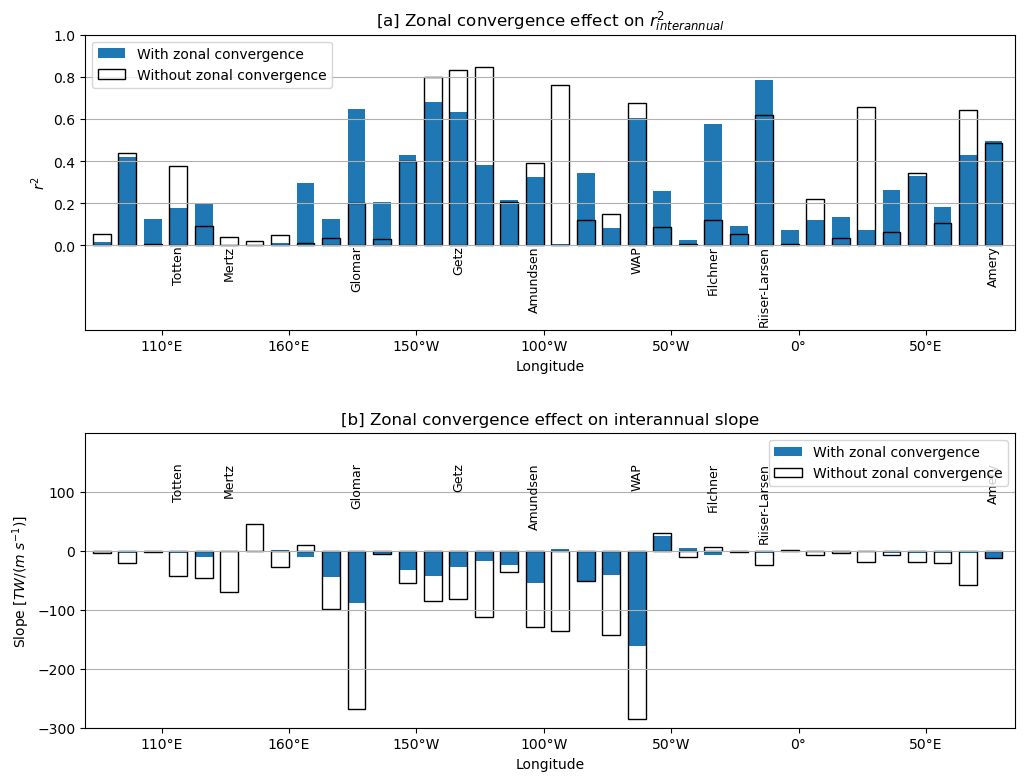

In [46]:
plt.figure(figsize=(12,9))
plt.subplots_adjust( hspace=.35)
#fig,ax_cric = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5))

ax_cric0 = plt.subplot(2,1,1)
#r_sq_annual_10deg.to_series().plot.bar(label='With zonal convergence')
plt.bar(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg,width=7,label='With zonal convergence')
#r_sq_annual_10deg_noZC.to_series().plot.bar(color='none',edgecolor='black',label='Without zonal convergence')
plt.bar(r_sq_annual_10deg_noZC.lon_bins,r_sq_annual_10deg_noZC,width=7,color='none',edgecolor='black',label='Without zonal convergence')
plt.legend()
plt.grid(axis='y')
plt.ylabel('$r^2$')
plt.ylim(-.4,1)
for i in range(9):
    plt.text(r_sq_annual_10deg_noZC.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.title('[a] Zonal convergence effect on $r^2_{interannual}$')
plt.yticks([0,.2,.4,.6,.8,1])
plt.xlim(-280,85)
ax_cric0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')

ax_cric1 = plt.subplot(2,1,2)
#slope_sq_annual_10deg.to_series().plot.bar(label='With zonal convergence')
plt.bar(slope_sq_annual_10deg.lon_bins,slope_sq_annual_10deg,width=7,label='With zonal convergence')
#slope_sq_annual_10deg_noZC.to_series().plot.bar(color='none',edgecolor='black',label='Without zonal convergence')
plt.bar(slope_sq_annual_10deg_noZC.lon_bins,slope_sq_annual_10deg_noZC,width=7,color='none',edgecolor='black',label='Without zonal convergence')
plt.legend()
plt.grid(axis='y')
plt.ylabel('Slope [$TW/ (m\ s^{-1})$]')
for i in range(9):
    plt.text(r_sq_annual_10deg_noZC.lon_bins[longitude_inds[i]], 150, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.ylim(-300,200)
plt.yticks([-300,-200,-100,0,100])
ax_cric1.xaxis.set_major_formatter(LongitudeFormatter())
plt.title('[b] Zonal convergence effect on interannual slope')
plt.xlabel('Longitude')
plt.xlim(-280,85)
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Zonal_convergence_effect_annual_13AUG2025.png',dpi=300,bbox_inches='tight')
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Zonal_convergence_effect_annual_13AUG2025.pdf',dpi=300,bbox_inches='tight')

In [50]:
r_sq_daily_10deg.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/r_sq_seasonal.nc')

(-280.0, 85.0)

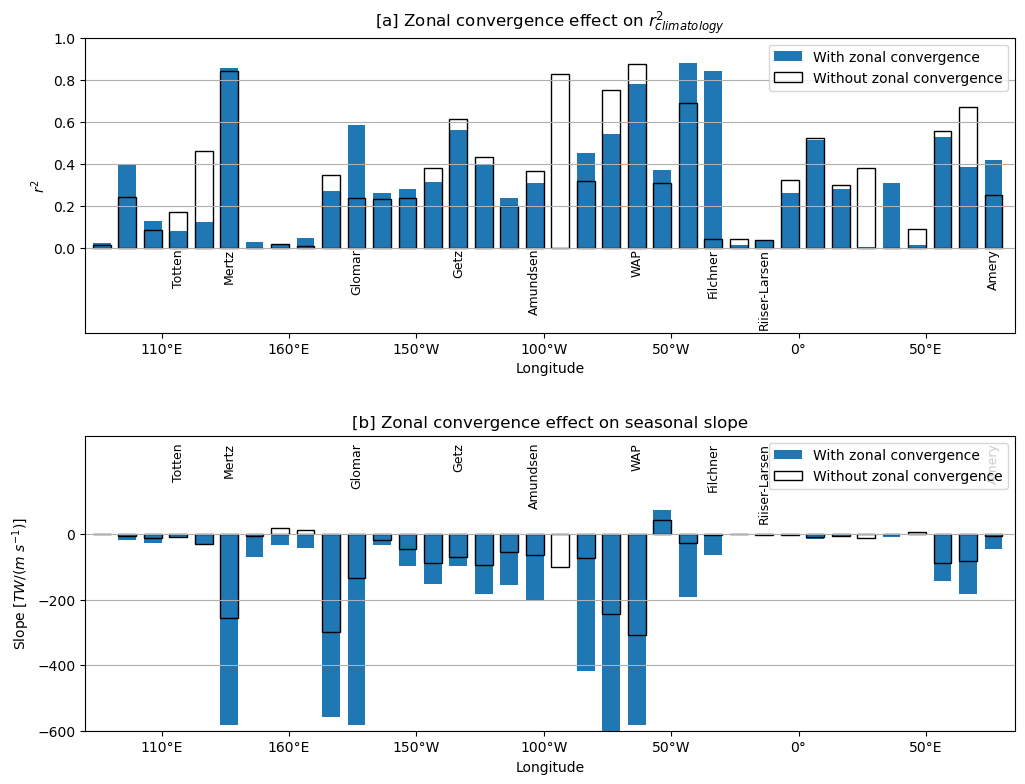

In [47]:
plt.figure(figsize=(12,9))
plt.subplots_adjust( hspace=.35)

ax_cric0 = plt.subplot(2,1,1)
#r_sq_daily_10deg.to_series().plot.bar(label='With zonal convergence')
plt.bar(r_sq_daily_10deg.lon_bins,r_sq_daily_10deg,width=7,label='With zonal convergence')
#r_sq_daily_10deg_noZC.to_series().plot.bar(color='none',edgecolor='black',label='Without zonal convergence')
plt.bar(r_sq_daily_10deg_noZC.lon_bins,r_sq_daily_10deg_noZC,width=7,color='none',edgecolor='black',label='Without zonal convergence')

plt.legend()
plt.grid(axis='y')
plt.ylabel('$r^2$')
plt.ylim(-.4,1)
for i in range(9):
    plt.text(r_sq_annual_10deg_noZC.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.title('[a] Zonal convergence effect on $r^2_{climatology}$')
plt.yticks([0,.2,.4,.6,.8,1])
ax_cric0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')
plt.xlim(-280,85)


ax_cric1 = plt.subplot(2,1,2)
#slope_sq_daily_10deg.to_series().plot.bar(label='With zonal convergence')
plt.bar(slope_sq_daily_10deg.lon_bins,slope_sq_daily_10deg,width=7,label='With zonal convergence')
#slope_sq_daily_10deg_noZC.to_series().plot.bar(color='none',edgecolor='black',label='Without zonal convergence')
plt.bar(slope_sq_daily_10deg_noZC.lon_bins,slope_sq_daily_10deg_noZC,width=7,color='none',edgecolor='black',label='Without zonal convergence')
plt.legend()
plt.grid(axis='y')
plt.ylabel('Slope [$TW/ (m\ s^{-1})$]')
for i in range(9):
    plt.text(r_sq_annual_10deg_noZC.lon_bins[longitude_inds[i]], 280, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.ylim(-600,300)
plt.yticks([-600,-400,-200,0,])
plt.title('[b] Zonal convergence effect on seasonal slope')
ax_cric1.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')
plt.xlim(-280,85)
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Zonal_convergence_effect_clim_13AUG2025.png',dpi=300,bbox_inches='tight')
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Zonal_convergence_effect_clim_13AUG2025.pdf',dpi=300,bbox_inches='tight')

In [53]:
40/360


0.1111111111111111

In [54]:
import cosima_cookbook as cc

session = cc.database.create_session()

In [55]:
lat_slice=slice(-90,-55)
depth_slice=slice(0,1500)
#T
T_iaf_monthly = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'temp', session,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(yt_ocean=lat_slice,st_ocean=depth_slice)-273.15
#'pot_rho_0'
σ0_iaf_monthly = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'pot_rho_0', session,frequency='1 monthly',chunks={"time":  '200MB'})\
.sel(yt_ocean=lat_slice,st_ocean=depth_slice)

In [56]:
# #extracting along contour
# T_iaf_monthly_along_contour = T_iaf_monthly.sel(xt_ocean=u_along_unbinned_fine.isel(time=0,potrho0=0).lon_along_contour.drop({'time','potrho0'})\
#                                                 ,yt_ocean=u_along_unbinned_fine.isel(time=0,potrho0=0).lat_along_contour.drop({'time','potrho0'}),method='nearest')
# σ0_iaf_monthly_along_contour = σ0_iaf_monthly.sel(xt_ocean=u_along_unbinned_fine.isel(time=0,potrho0=0).lon_along_contour.drop({'time','potrho0'})\
#                                                 ,yt_ocean=u_along_unbinned_fine.isel(time=0,potrho0=0).lat_along_contour.drop({'time','potrho0'}),method='nearest')
# #dzt - I will just use the first year mean dzt to save memory
# dzt_iaf_monthly = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'dzt', session,frequency='1 monthly',chunks={"time":  '200MB'})\
# .isel(time=slice(0,12)).sel(yt_ocean=lat_slice,st_ocean=depth_slice)
# dzt_iaf_monthly_along_contour = dzt_iaf_monthly.sel(xt_ocean=u_along_unbinned_fine.isel(time=0,potrho0=0).lon_along_contour.drop({'time','potrho0'})\
#                                                 ,yt_ocean=u_along_unbinned_fine.isel(time=0,potrho0=0).lat_along_contour.drop({'time','potrho0'}),method='nearest').mean('time')
# dzt_iaf_monthly_along_contour.load()
# T_iaf_monthly_along_contour.load()
# σ0_iaf_monthly_along_contour.load()
# we probably should save those so we dont have to run it again
# σ0_iaf_monthly_along_contour.to_netcdf('/g/data/x77/wf4500/ASC_project/T_Sigma_along_contour/potrho0_along_contour.nc')
# T_iaf_monthly_along_contour.to_netcdf('/g/data/x77/wf4500/ASC_project/T_Sigma_along_contour/T_along_contour.nc')
# dzt_iaf_monthly_along_contour.to_netcdf('/g/data/x77/wf4500/ASC_project/T_Sigma_along_contour/dzt_along_contour.nc')

In [57]:
σ0_iaf_monthly_along_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/T_Sigma_along_contour/potrho0_along_contour.nc').pot_rho_0
T_iaf_monthly_along_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/T_Sigma_along_contour/T_along_contour.nc').temp
dzt_iaf_monthly_along_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/T_Sigma_along_contour/dzt_along_contour.nc').dzt

lets...

1 - Bin both T and sigma in 10 degree bins

2 - Convert T from Z to sigma

3 - Separate T on CDW layer

4 - Calculate T anual mean aling isobath and T standard deviation along isobath

5 - See if regions with a high variability in CDW T align with regions with high correlations (I.e., CDW just incur a higher variability in these places, while in other places variability is just too small to have any correlation).

In [58]:
#creating bin edges for 10-deg bins
lon_edges_west_forT = np.array(CSHT_along_monthly.lon_bins-5)
lon_edges_east_forT = np.array(CSHT_along_monthly.lon_bins+5)
lon_edges_forT = np.append(lon_edges_west_forT,lon_edges_east_forT[-1])
lon_edges_forT[0]=-282
lon_edges_forT[-1]=82
lon_edges_forT

array([-282. , -268.5, -258.5, -248.5, -238.5, -228.5, -218.5, -208.5,
       -198.5, -188.5, -178.5, -168.5, -158.5, -148.5, -138.5, -128.5,
       -118.5, -108.5,  -98.5,  -88.5,  -78.5,  -68.5,  -58.5,  -48.5,
        -38.5,  -28.5,  -18.5,   -8.5,    1.5,   11.5,   21.5,   31.5,
         41.5,   51.5,   61.5,   71.5,   82. ])

In [59]:
#10deg binning - I should redo-it weighting by area, but anyways
T_iaf_monthly_along_contour_10_deg = T_iaf_monthly_along_contour.groupby_bins("xt_ocean",lon_edges_forT).mean()
σ0_iaf_monthly_along_contour_10_deg = σ0_iaf_monthly_along_contour.groupby_bins("xt_ocean",lon_edges_forT).mean()
dzt_iaf_monthly_along_contour_10_deg = dzt_iaf_monthly_along_contour.groupby_bins("xt_ocean",lon_edges_forT).mean()

In [60]:
T_iaf_monthly_along_contour_10_deg = T_iaf_monthly_along_contour_10_deg.rename({'xt_ocean_bins':'lon_bins'})
T_iaf_monthly_along_contour_10_deg['lon_bins']=CSHT_along_monthly.lon_bins
σ0_iaf_monthly_along_contour_10_deg = σ0_iaf_monthly_along_contour_10_deg.rename({'xt_ocean_bins':'lon_bins'})
σ0_iaf_monthly_along_contour_10_deg['lon_bins']=CSHT_along_monthly.lon_bins
dzt_iaf_monthly_along_contour_10_deg = dzt_iaf_monthly_along_contour_10_deg.rename({'xt_ocean_bins':'lon_bins'})
dzt_iaf_monthly_along_contour_10_deg['lon_bins']=CSHT_along_monthly.lon_bins

In [61]:
#sigma binning
from xhistogram.xarray import histogram
#defining sigma bins....
rho0_contour_forT = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
targetbins_forT = np.append(np.append(1020,np.append(np.arange(1023,1027,.15),\
                                 np.linspace(1027,rho0_contour_forT.pot_rho_0.max().values+0.2,80))),1030)-1000

In [62]:
#binning T into sigma contours
T_sigma_monthly_10_deg = histogram(σ0_iaf_monthly_along_contour_10_deg, 
                          bins = targetbins_forT+1000, 
                          dim = ['st_ocean'],
                          weights = T_iaf_monthly_along_contour_10_deg*dzt_iaf_monthly_along_contour_10_deg)/\
histogram(σ0_iaf_monthly_along_contour_10_deg, 
                          bins = targetbins_forT+1000, 
                          dim = ['st_ocean'],
                          weights = dzt_iaf_monthly_along_contour_10_deg)

In [63]:
#renaming
T_sigma_monthly_10_deg = T_sigma_monthly_10_deg.rename({'pot_rho_0_bin':'potrho0'})
T_sigma_monthly_10_deg['potrho0'] = age_mask.potrho0

In [64]:
T_sigma_monthly_10_deg['time']=vol_bins.time

In [65]:
#getting CDW layer
T_sigma_monthly_10_deg_CDWmean = (T_sigma_monthly_10_deg*age_mask.CDW_mask).weighted((age_mask.CDW_mask*vol_bins.volume).fillna(0)).mean('potrho0').mean('time').compute()
T_sigma_monthly_10_deg_CDWstd = (T_sigma_monthly_10_deg*age_mask.CDW_mask).weighted((age_mask.CDW_mask*vol_bins.volume).fillna(0)).mean('potrho0').std('time').compute()

(-1.0, 1.0)

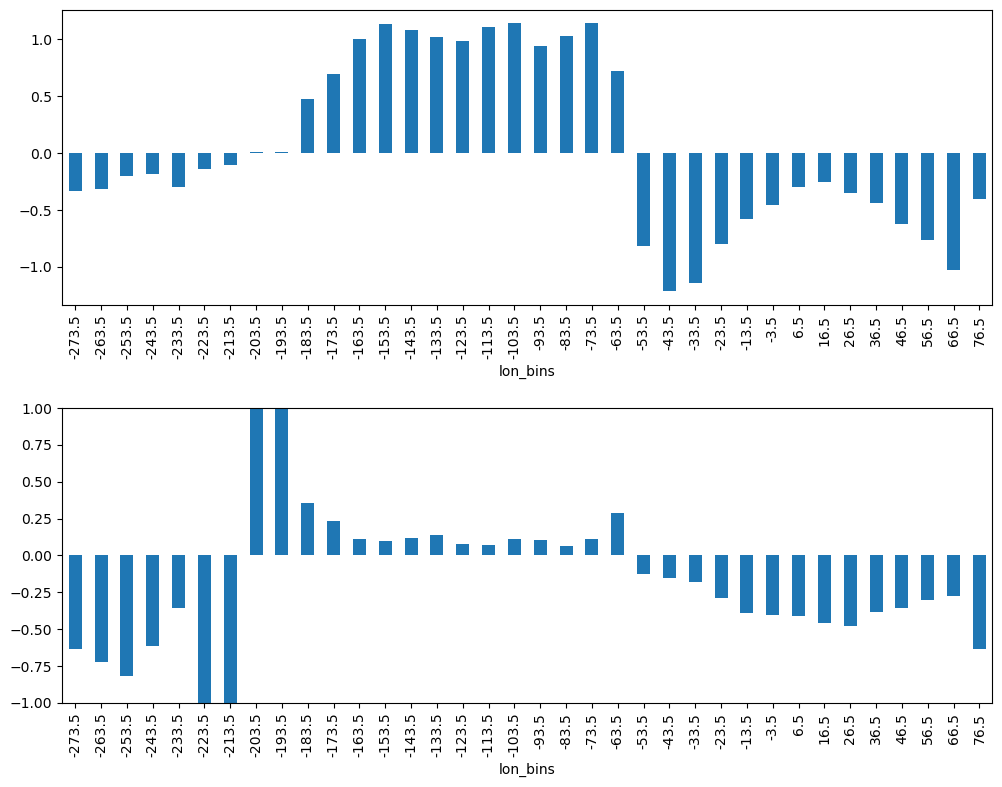

In [66]:
#T on CDW layer


plt.figure(figsize=(12,9))
plt.subplots_adjust( hspace=.35)

plt.subplot(2,1,1)
(T_sigma_monthly_10_deg_CDWmean).to_series().plot.bar()

plt.subplot(2,1,2)
(T_sigma_monthly_10_deg_CDWstd/T_sigma_monthly_10_deg_CDWmean).to_series().plot.bar()
plt.ylim(-1,1)

In [67]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [68]:
#calculating the standard deviations of heat transport
CSHT_along_annual_forplot = (CSHT_along_monthly.CSHT_ZC_lon_binned*age_mask.CDW_mask).sum('potrho0').resample(time='1Y').mean().compute()
CSHT_along_annual_std_forplot = (CSHT_along_monthly.CSHT_ZC_lon_binned*age_mask.CDW_mask).sum('potrho0').resample(time='1Y').mean().std('time').compute()
CSHT_along_annualmean_forplot = (CSHT_along_monthly.CSHT_ZC_lon_binned*age_mask.CDW_mask).sum('potrho0').resample(time='1Y').mean().mean('time').compute()

In [69]:
#calculating standard deviations of ASC
U_along_annual_forplot = (u_along.U*age_mask.CDW_mask).weighted(vol_bins.volume.fillna(0)).mean('potrho0').resample(time='1Y').mean().compute()
U_along_annual_forplot_std = (u_along.U*age_mask.CDW_mask).weighted(vol_bins.volume.fillna(0)).mean('potrho0').resample(time='1Y').mean().std('time').compute()
U_along_annualmean_forplot = (u_along.U*age_mask.CDW_mask).weighted(vol_bins.volume.fillna(0)).mean('potrho0').resample(time='1Y').mean().mean('time').compute()

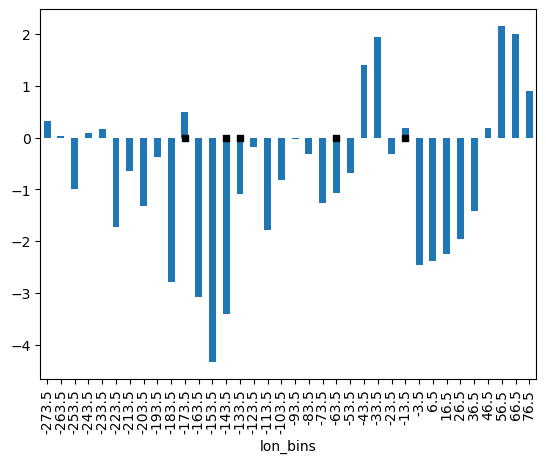

In [70]:
(CSHT_along_annualmean_forplot/CSHT_along_annual_std_forplot).to_series().plot.bar()
plt.scatter([13,14,21,10,26],[0,0,0,0,0],marker='s',s=20,color='k')

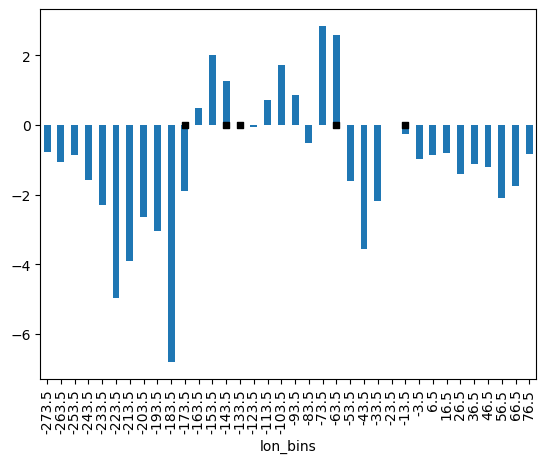

In [71]:
(U_along_annualmean_forplot/U_along_annual_forplot_std).to_series().plot.bar()
plt.scatter([13,14,21,10,26],[0,0,0,0,0],marker='s',s=20,color='k')

In [72]:
#can the volume explain something?
Vol_annual_std = (vol_bins.volume*age_mask.CDW_mask).sum('potrho0').resample(time='1Y').mean().std('time').compute()
Vol_annual_mean = (vol_bins.volume*age_mask.CDW_mask).sum('potrho0').resample(time='1Y').mean().mean('time').compute()

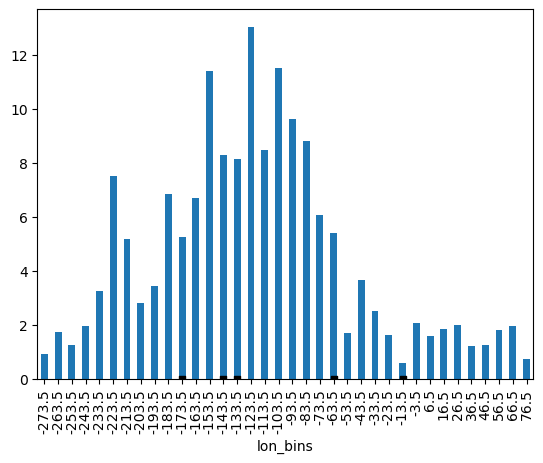

In [73]:
(Vol_annual_mean/Vol_annual_std ).to_series().plot.bar()
plt.scatter([13,14,21,10,26],[0,0,0,0,0],marker='s',s=20,color='k')

(-4.0, 4.0)

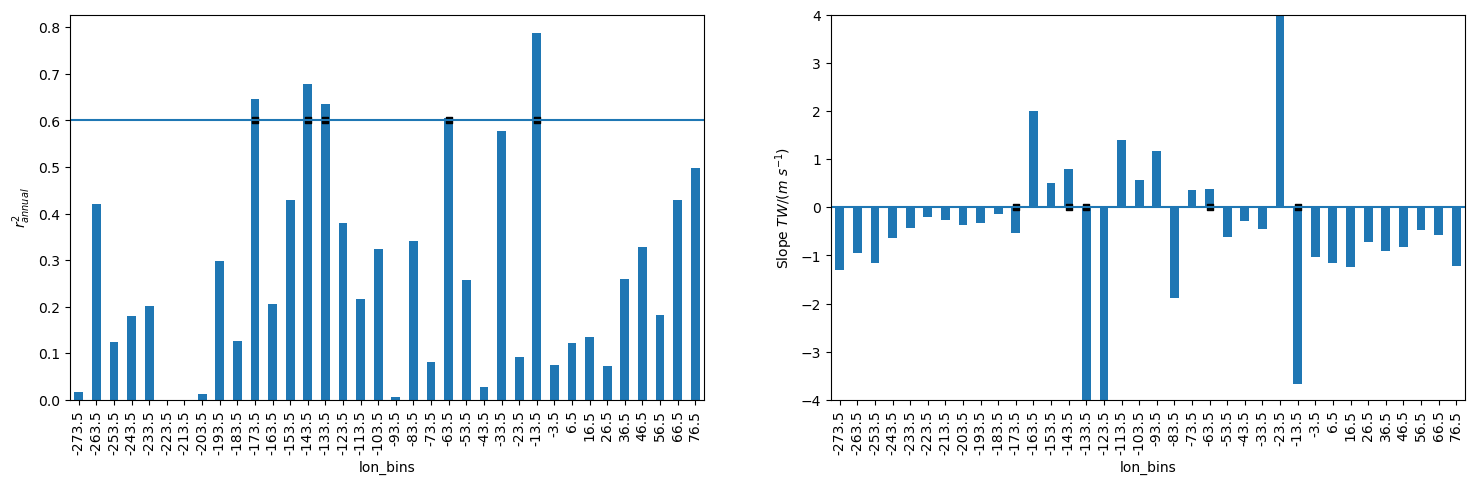

In [74]:
plt.figure(figsize=(18,5))
ax0 = plt.subplot(1,2,1)

r_sq_annual_10deg.to_series().plot.bar()
plt.plot([-280,80],[0.6,0.6])
plt.scatter([13,14,21,10,26],[.6,.6,.6,.6,.6],marker='s',s=20,color='k')
plt.ylabel('$r^2_{annual}$')


ax1 = plt.subplot(1,2,2)
(U_along_annual_forplot_std/U_along_annualmean_forplot).to_series().plot.bar()
plt.plot([-280,80],[0,0])
plt.scatter([13,14,21,10,26],[.01,.01,.01,.01,.01],marker='s',s=20,color='k')
plt.ylabel('Slope $TW/(m\ s^{-1})$')
plt.ylim(-4,4)


based on the plot above, it doesnt seem like the regions with high correlation can be explained by how strong and variable ASC is

Text(0, 0.5, 'Slope $TW/(m\\ s^{-1})$')

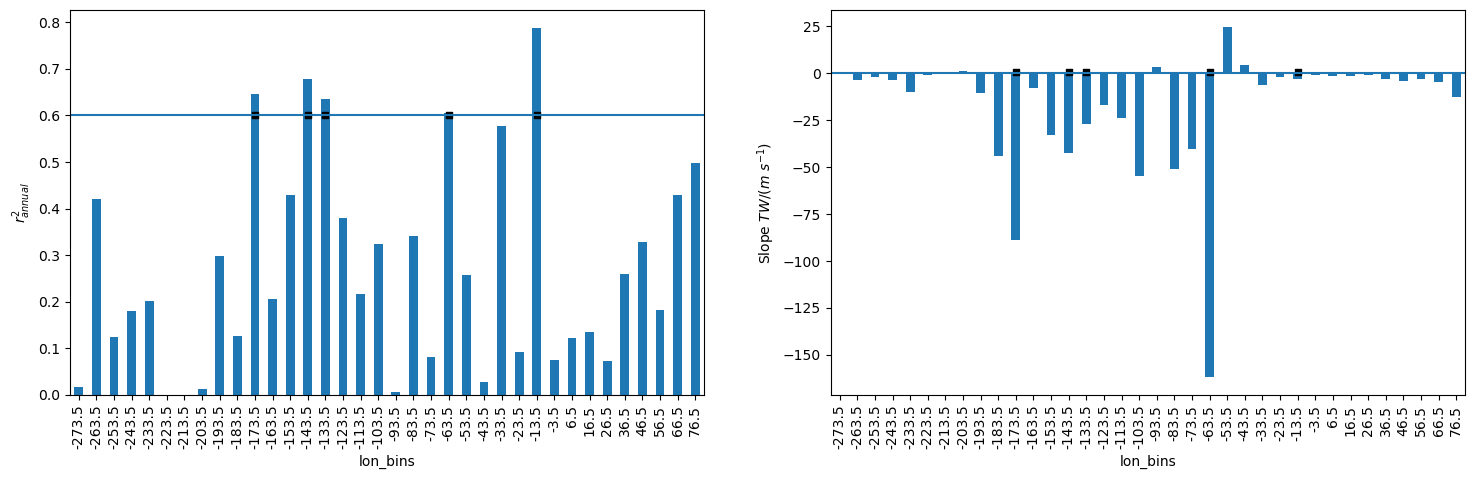

In [75]:
plt.figure(figsize=(18,5))
ax0 = plt.subplot(1,2,1)

r_sq_annual_10deg.to_series().plot.bar()
plt.plot([-280,80],[0.6,0.6])
plt.scatter([13,14,21,10,26],[.6,.6,.6,.6,.6],marker='s',s=20,color='k')
plt.ylabel('$r^2_{annual}$')


ax1 = plt.subplot(1,2,2)
slope_sq_annual_10deg.to_series().plot.bar()
plt.plot([-280,80],[0,0])
plt.scatter([13,14,21,10,26],[.6,.6,.6,.6,.6],marker='s',s=20,color='k')
plt.ylabel('Slope $TW/(m\ s^{-1})$')


In [76]:
print('In the interannual series, only ' + str(round((5/36)*100)) + '% of bins have r2>0.6')

In the interannual series, only 14% of bins have r2>0.6


Text(0, 0.5, 'Slope $TW/(m\\ s^{-1})$')

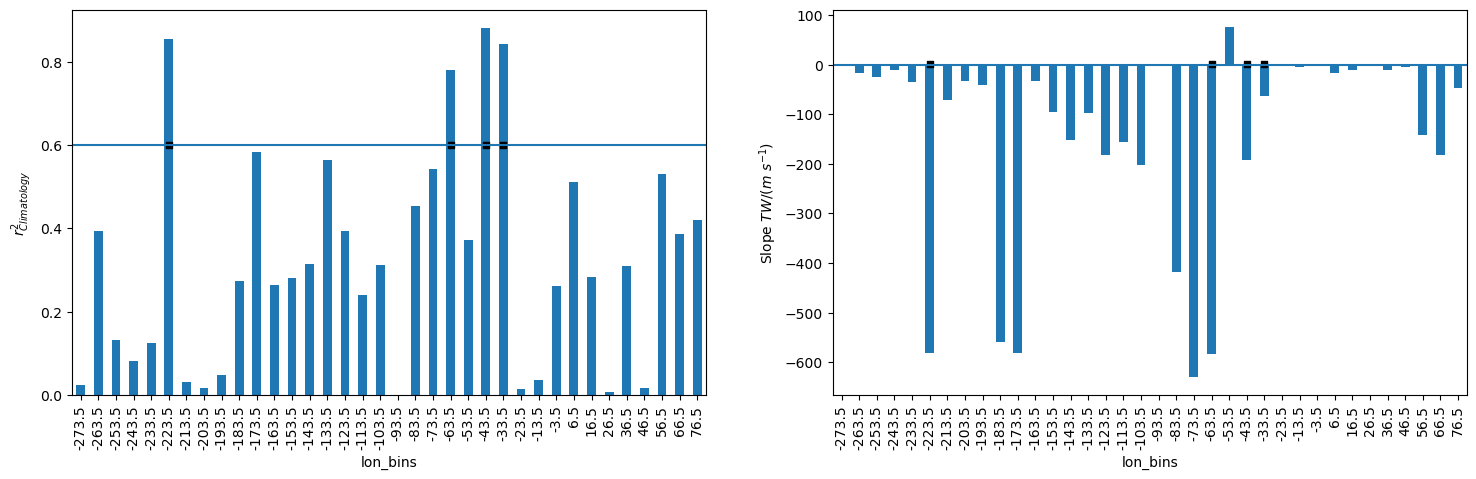

In [77]:
plt.figure(figsize=(18,5))
ax0 = plt.subplot(1,2,1)

r_sq_daily_10deg.to_series().plot.bar()
plt.plot([-280,80],[0.6,0.6])
plt.scatter([5,21,23,24],[.6,.6,.6,.6],marker='s',s=20,color='k')
plt.ylabel('$r^2_{Climatology}$')


ax1 = plt.subplot(1,2,2)
slope_sq_daily_10deg.to_series().plot.bar()
plt.plot([-280,80],[0,0])
plt.scatter([5,21,23,24],[.6,.6,.6,.6],marker='s',s=20,color='k')
plt.ylabel('Slope $TW/(m\ s^{-1})$')

In [78]:
print('In the seasonal series, only ' + str(round((4/36)*100)) + '% of bins have r2>0.6')

In the seasonal series, only 11% of bins have r2>0.6


## Do some first quick plots to look at correlations in different layers and different time scales:

In [79]:
# get things ready for plotting (land mask and colormap)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# Data required for lat/lon mapping
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
lat_slice = slice(-80, -59)
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Plot annual correlations in CDW layer:

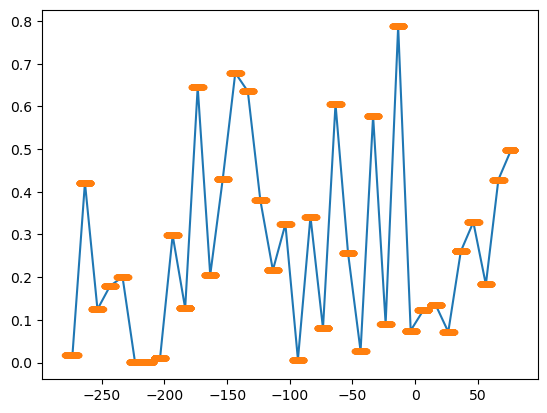

In [80]:
# get lat/lon on contour to interp onto:
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0)
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0)

# first fix lon dimension on r^2:
r_sq_annual_10deg['lon_bins'] = r_sq_annual_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_annual_10deg_interp = r_sq_annual_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg,'.-')
plt.plot(r_sq_annual_10deg_interp.lon_bins,r_sq_annual_10deg_interp,'.')

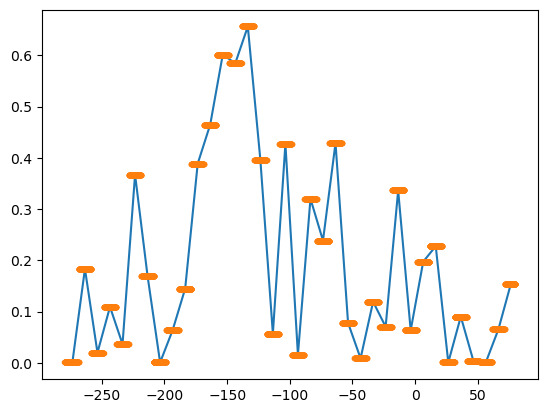

In [81]:
# first fix lon dimension on r^2:
r_sq_all_10deg['lon_bins'] = r_sq_all_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_all_10deg_interp = r_sq_all_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_all_10deg.lon_bins,r_sq_all_10deg,'.-')
plt.plot(r_sq_all_10deg_interp.lon_bins,r_sq_all_10deg_interp,'.')

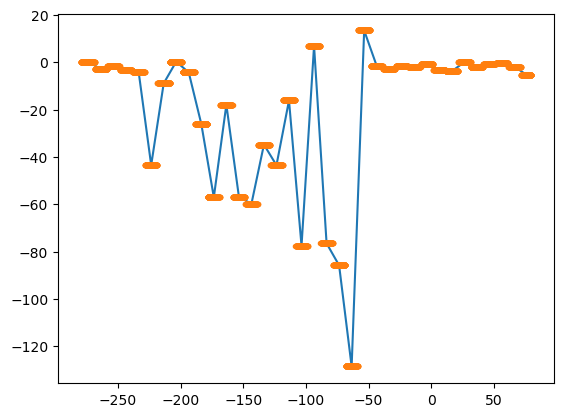

In [82]:
# first fix lon dimension on r^2:
slope_sq_all_10deg['lon_bins'] = slope_sq_all_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_all_10deg_interp = slope_sq_all_10deg.interp(lon_bins=CSHT_lon_along_contour, \
                                                      method='nearest',kwargs={"fill_value": "extrapolate"})
# plot to check:
plt.plot(slope_sq_all_10deg.lon_bins,slope_sq_all_10deg,'.-')
plt.plot(slope_sq_all_10deg_interp.lon_bins,slope_sq_all_10deg_interp,'.')

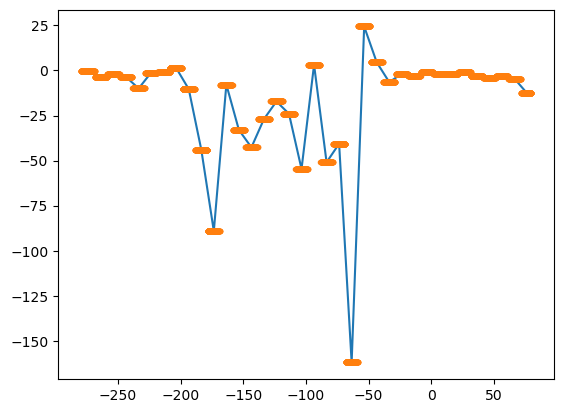

In [83]:
# first fix lon dimension on r^2:
slope_sq_annual_10deg['lon_bins'] = slope_sq_annual_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_annual_10deg_interp = slope_sq_annual_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(slope_sq_annual_10deg.lon_bins,slope_sq_annual_10deg,'.-')
plt.plot(slope_sq_annual_10deg_interp.lon_bins,slope_sq_annual_10deg_interp,'.')

In [84]:
# # first fix lon dimension on r^2:
# r_sq_clima_10deg['lon_bins'] = r_sq_clima_10deg.lon_bins

# # now interpolate onto lon_along_contour:
# r_sq_clima_10deg_interp = r_sq_clima_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# # plot to check:
# plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg,'.-')
# plt.plot(r_sq_clima_10deg_interp.lon_bins,r_sq_clima_10deg_interp,'.')

In [85]:
# # first fix lon dimension on r^2:
# slope_sq_clima_10deg['lon_bins'] = slope_sq_clima_10deg.lon_bins

# # now interpolate onto lon_along_contour:
# slope_sq_clima_10deg_interp = slope_sq_clima_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# # plot to check:
# plt.plot(slope_sq_clima_10deg.lon_bins,slope_sq_clima_10deg,'.-')
# plt.plot(slope_sq_clima_10deg_interp.lon_bins,slope_sq_clima_10deg_interp,'.')

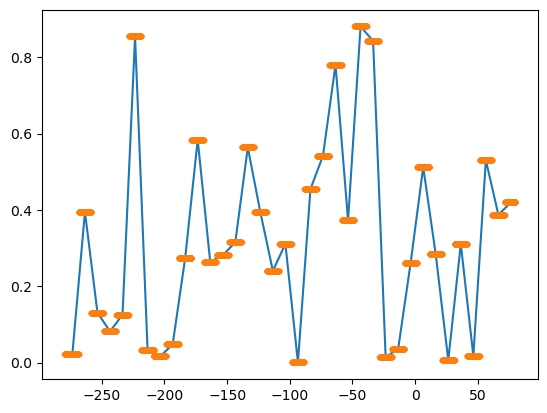

In [86]:
# first fix lon dimension on r^2:
r_sq_daily_10deg['lon_bins'] = r_sq_daily_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_daily_10deg_interp = r_sq_daily_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_daily_10deg.lon_bins,r_sq_daily_10deg,'.-')
plt.plot(r_sq_daily_10deg_interp.lon_bins,r_sq_daily_10deg_interp,'.')

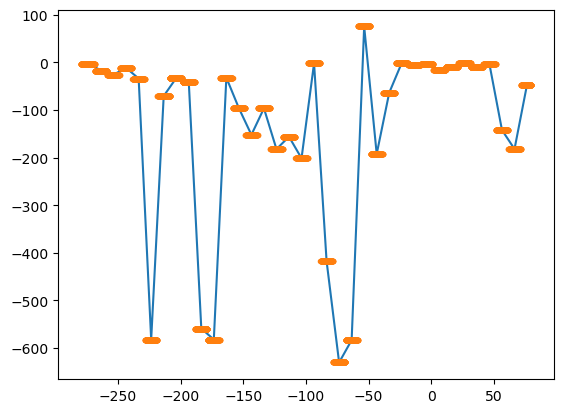

In [87]:
# first fix lon dimension on r^2:
slope_sq_daily_10deg['lon_bins'] = slope_sq_daily_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_daily_10deg_interp = slope_sq_daily_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(slope_sq_daily_10deg.lon_bins,slope_sq_daily_10deg,'.-')
plt.plot(slope_sq_daily_10deg_interp.lon_bins,slope_sq_daily_10deg_interp,'.')

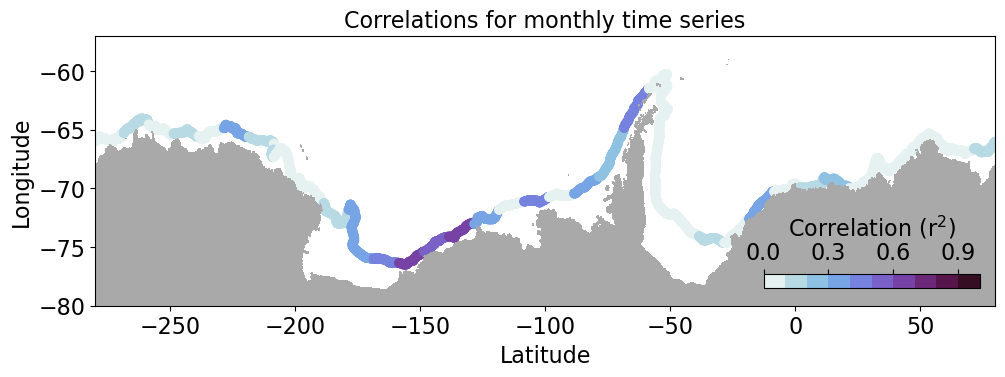

In [88]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_all_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude',fontsize=fontsize)
ax_cric.set_xlabel('Latitude',fontsize=fontsize)
ax_cric.set_title('Correlations for monthly time series',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

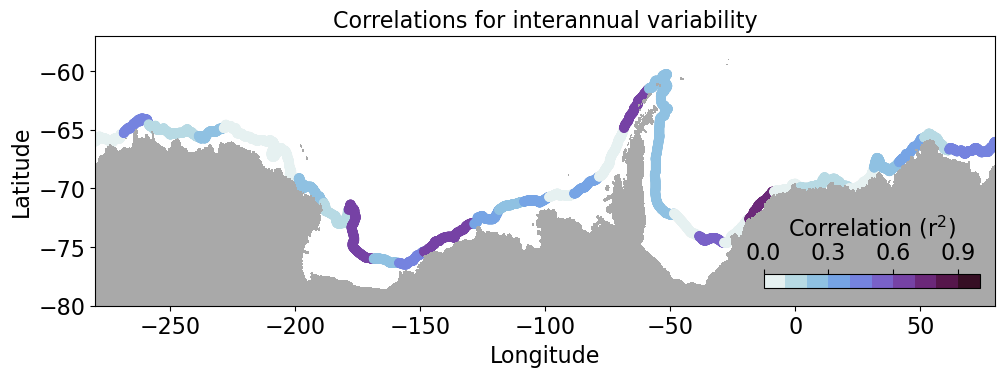

In [89]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_annual_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Latitude',fontsize=fontsize)
ax_cric.set_xlabel('Longitude',fontsize=fontsize)
ax_cric.set_title('Correlations for interannual variability',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

In [90]:
def subplot_corr_along_contour(subplot_ax, quantity, type_quantity):
    ax_cric = subplot_ax#.add_axes([0,0,0.9,.9])

    if type_quantity == 'corr':
        scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap = discrete_cmap(10, cmocean.dense), 
                               vmin = 0, vmax = 1)
    elif type_quantity == 'slope':
        scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap =custom_cmap_slope, 
                       vmin = -120,vmax =120) # 150 for cric ##-300,300 for CDW, -90, 90 for AASW
        # for CDW daily climatology only below
        if subplot_ax == ax[1,1]:
            scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap =custom_cmap_slope, 
                       vmin = -120,vmax =120)
                       
            
    ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)
    ax_cric.set_ylim([-80,-57])
    #ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
    #ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
    ax_cric.set_title(quantity.name,fontsize=fontsize)
    ax_cric.tick_params(labelsize=fontsize)
    ax_cric.set_facecolor('gainsboro') 

    '''
    axins1 = inset_axes(
        ax_cric,
        width="24%",  # width: 50% of parent_bbox width
        height="5%", # height: 5%
        loc='lower left',
        bbox_to_anchor = (0.735,0.04,1,1),
        bbox_transform=ax_cric.transAxes)
    cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
    
    
    if type_quantity == 'corr':
        cb.set_ticks([0,0.3,0.6,.9])
        cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
        
    elif type_quantity == 'slope':
        cb.set_label('Slope (TW/(m/s))',fontsize=fontsize)

    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.tick_params(labelsize=fontsize)
    '''    
    ax_cric.yaxis.set_major_formatter(LatitudeFormatter())
    ax_cric.xaxis.set_major_formatter(LongitudeFormatter())

    if (ax_cric == ax[2,0]) or (ax_cric == ax[2,1])  :
        cax = inset_axes(ax_cric,        
                        width="70%",  # width: 50% of parent_bbox width
                        height="5%", # height: 5%
                        loc='lower center',
                        bbox_to_anchor = (0,-0.19,1,1),
                        bbox_transform=ax_cric.transAxes)
        cb = fig.colorbar(scat, cax = cax, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
        cb.ax.tick_params(labelsize=fontsize)
        
        if type_quantity == 'corr':
            cb.set_ticks([0,0.3,0.6,.9])
            cb.set_label('Correlation [r$^2$]',fontsize=fontsize)
            
        elif type_quantity == 'slope':
            cb.set_label('Slope [TW/(m/s)]',fontsize=fontsize)
            
    return

In [91]:
# assigining numbers by regime clustering mask
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
clustering_mask_sum = xr.concat([clustering_mask.regimes_mask.isel(regime = reg_no) * (reg_no+1) for reg_no in range(3)], dim = 'regime').sum(dim = 'regime')


In [92]:
import matplotlib.colors as mcolors

def custom_curl_cmap():
    # Get the original cmocean.cm.curl colormap
    original_cmap = cmocean.curl

    # Create a new colormap by adding a white band around zero
    # We define the number of colors for the colormap
    num_colors = 256

    # Create the original colormap and a new one for white band
    new_colors = original_cmap(np.linspace(0, 1, num_colors))

    # Define the position of the white band
    mid_point = num_colors // 2  # Middle index
    band_width = round(0.1*256)  # Width of the white band -- middle 10% of range

    # Set the colors in the middle to white
    new_colors[mid_point - band_width//2 : mid_point + band_width//2] = [1, 1, 1, 1]  # RGBA for white

    # Create a new colormap from the modified color array
    custom_cmap = mcolors.ListedColormap(new_colors)

    return custom_cmap

In [93]:
custom_cmap_slope = custom_curl_cmap()

In [94]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


In [95]:
ASC_mask_wilma_dir = '/g/data/x77/wgh581/Post_Process/access-om2/ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz'

ASC_mask_wilma = np.load(ASC_mask_wilma_dir)


data_path_wilma = '/g/data/x77/wgh581/Post_Process/access-om2/'
file_name_wilma = 'Antarctic_slope_contour_1km_velocities_plt_approach.npz'

data = np.load(data_path_wilma + file_name_wilma)
data['lon_along_contour'].shape

lon_along_contour_formask = data['lon_along_contour'][:-1]
ASC_mask_wilma_forplot = ASC_mask_wilma['ASC_regimes_annual'][:-1]

ASC_mask_wilma_forplot =  np.vstack((ASC_mask_wilma_forplot,ASC_mask_wilma_forplot))
#converting to the propper colorbar numbers, as the ones we use are different than wilmas;
ASC_mask_wilma_forplot = -np.where(ASC_mask_wilma_forplot ==0,3,ASC_mask_wilma_forplot )

In [96]:
lon_bin=10
bin_edges = np.arange(CSHT_along.lon_bin_midpoints[0], CSHT_along.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHT_along.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])

In [97]:
hu_transect_og = cc.querying.getvar('01deg_jra55v140_iaf_cycle3','hu',session,n=1).compute()

In [98]:
CSHT_lat_along_contour_londim = CSHT_lat_along_contour\
.rename({'contour_index':'lon_along_contour'}).copy()
CSHT_lat_along_contour_londim['lon_along_contour'] = CSHT_lon_along_contour.values

lat_bins_10deg = 1+ CSHT_lat_along_contour_londim.groupby_bins('lon_along_contour', bins=bin_edges).mean('lon_along_contour').compute()

CSHT_lon_along_contour_forslices = CSHT_lon_along_contour.rename({'contour_index':'lon_along_contour0'}).copy()
CSHT_lon_along_contour_forslices['lon_along_contour0'] = CSHT_lon_along_contour.values
lon_slices_west = -1.5 + CSHT_lon_along_contour_forslices.groupby_bins('lon_along_contour0', bins=bin_edges).min('lon_along_contour0')
lon_slices_east = -1.4 + CSHT_lon_along_contour_forslices.groupby_bins('lon_along_contour0', bins=bin_edges).max('lon_along_contour0')

longitude_slice = r_sq_annual_10deg.lon_bins.values
longitude_slices = np.array([longitude_slice[5],longitude_slice[-15], longitude_slice[14], longitude_slice[3],\
                   longitude_slice[10],longitude_slice[17],\
                   longitude_slice[-12],longitude_slice[-10], longitude_slice[-1],\
                   longitude_slice[1]])
# longitude_slices = np.vstack((lon_slices_east.values,lon_slices_west.values))
# longitude_slices[:,0]

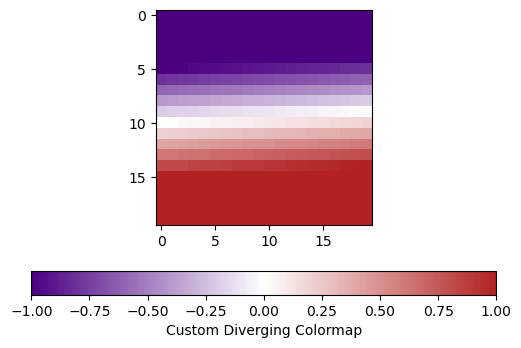

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a custom colormap
colors = ["indigo", "white", "firebrick"]  # Negative, Zero, Positive
experimental_cmap = mcolors.LinearSegmentedColormap.from_list("custom_div", colors, N=256)

# Create a normalization that centers white at 0
divnorm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Test the colormap with a sample plot
x = np.linspace(-2, 2, 400).reshape(20, 20)  # Sample data
fig, ax = plt.subplots(figsize=(6, 4))
img = ax.imshow(x, cmap=experimental_cmap, norm=divnorm)

# Add a colorbar
cbar = plt.colorbar(img, ax=ax, orientation="horizontal")
cbar.set_label("Custom Diverging Colormap")

plt.show()

In [100]:
import matplotlib.colors as mcolors

def custom_curl_cmap():
    # Get the original cmocean.cm.curl colormap
    #original_cmap = cmocean.curl
    original_cmap = experimental_cmap

    # Create a new colormap by adding a white band around zero
    # We define the number of colors for the colormap
    num_colors = 256

    # Create the original colormap and a new one for white band
    new_colors = original_cmap(np.linspace(0, 1, num_colors))
    # Define the position of the white band
    mid_point = num_colors // 2  # Middle index
    band_width = round(0.000001*256)  # Width of the white band -- middle 10% of range

    # Set the colors in the middle to white
    new_colors[mid_point - band_width//2 : mid_point + band_width//2] = [1, 1, 1, 1]  # RGBA for white
    
    # Create a new colormap from the modified color array
    custom_cmap = mcolors.ListedColormap(new_colors)

    return custom_cmap

In [101]:
from matplotlib.patches import FancyArrowPatch

In [102]:
#version 1, black box around percentage >=5%

# Plots using determination coefficient

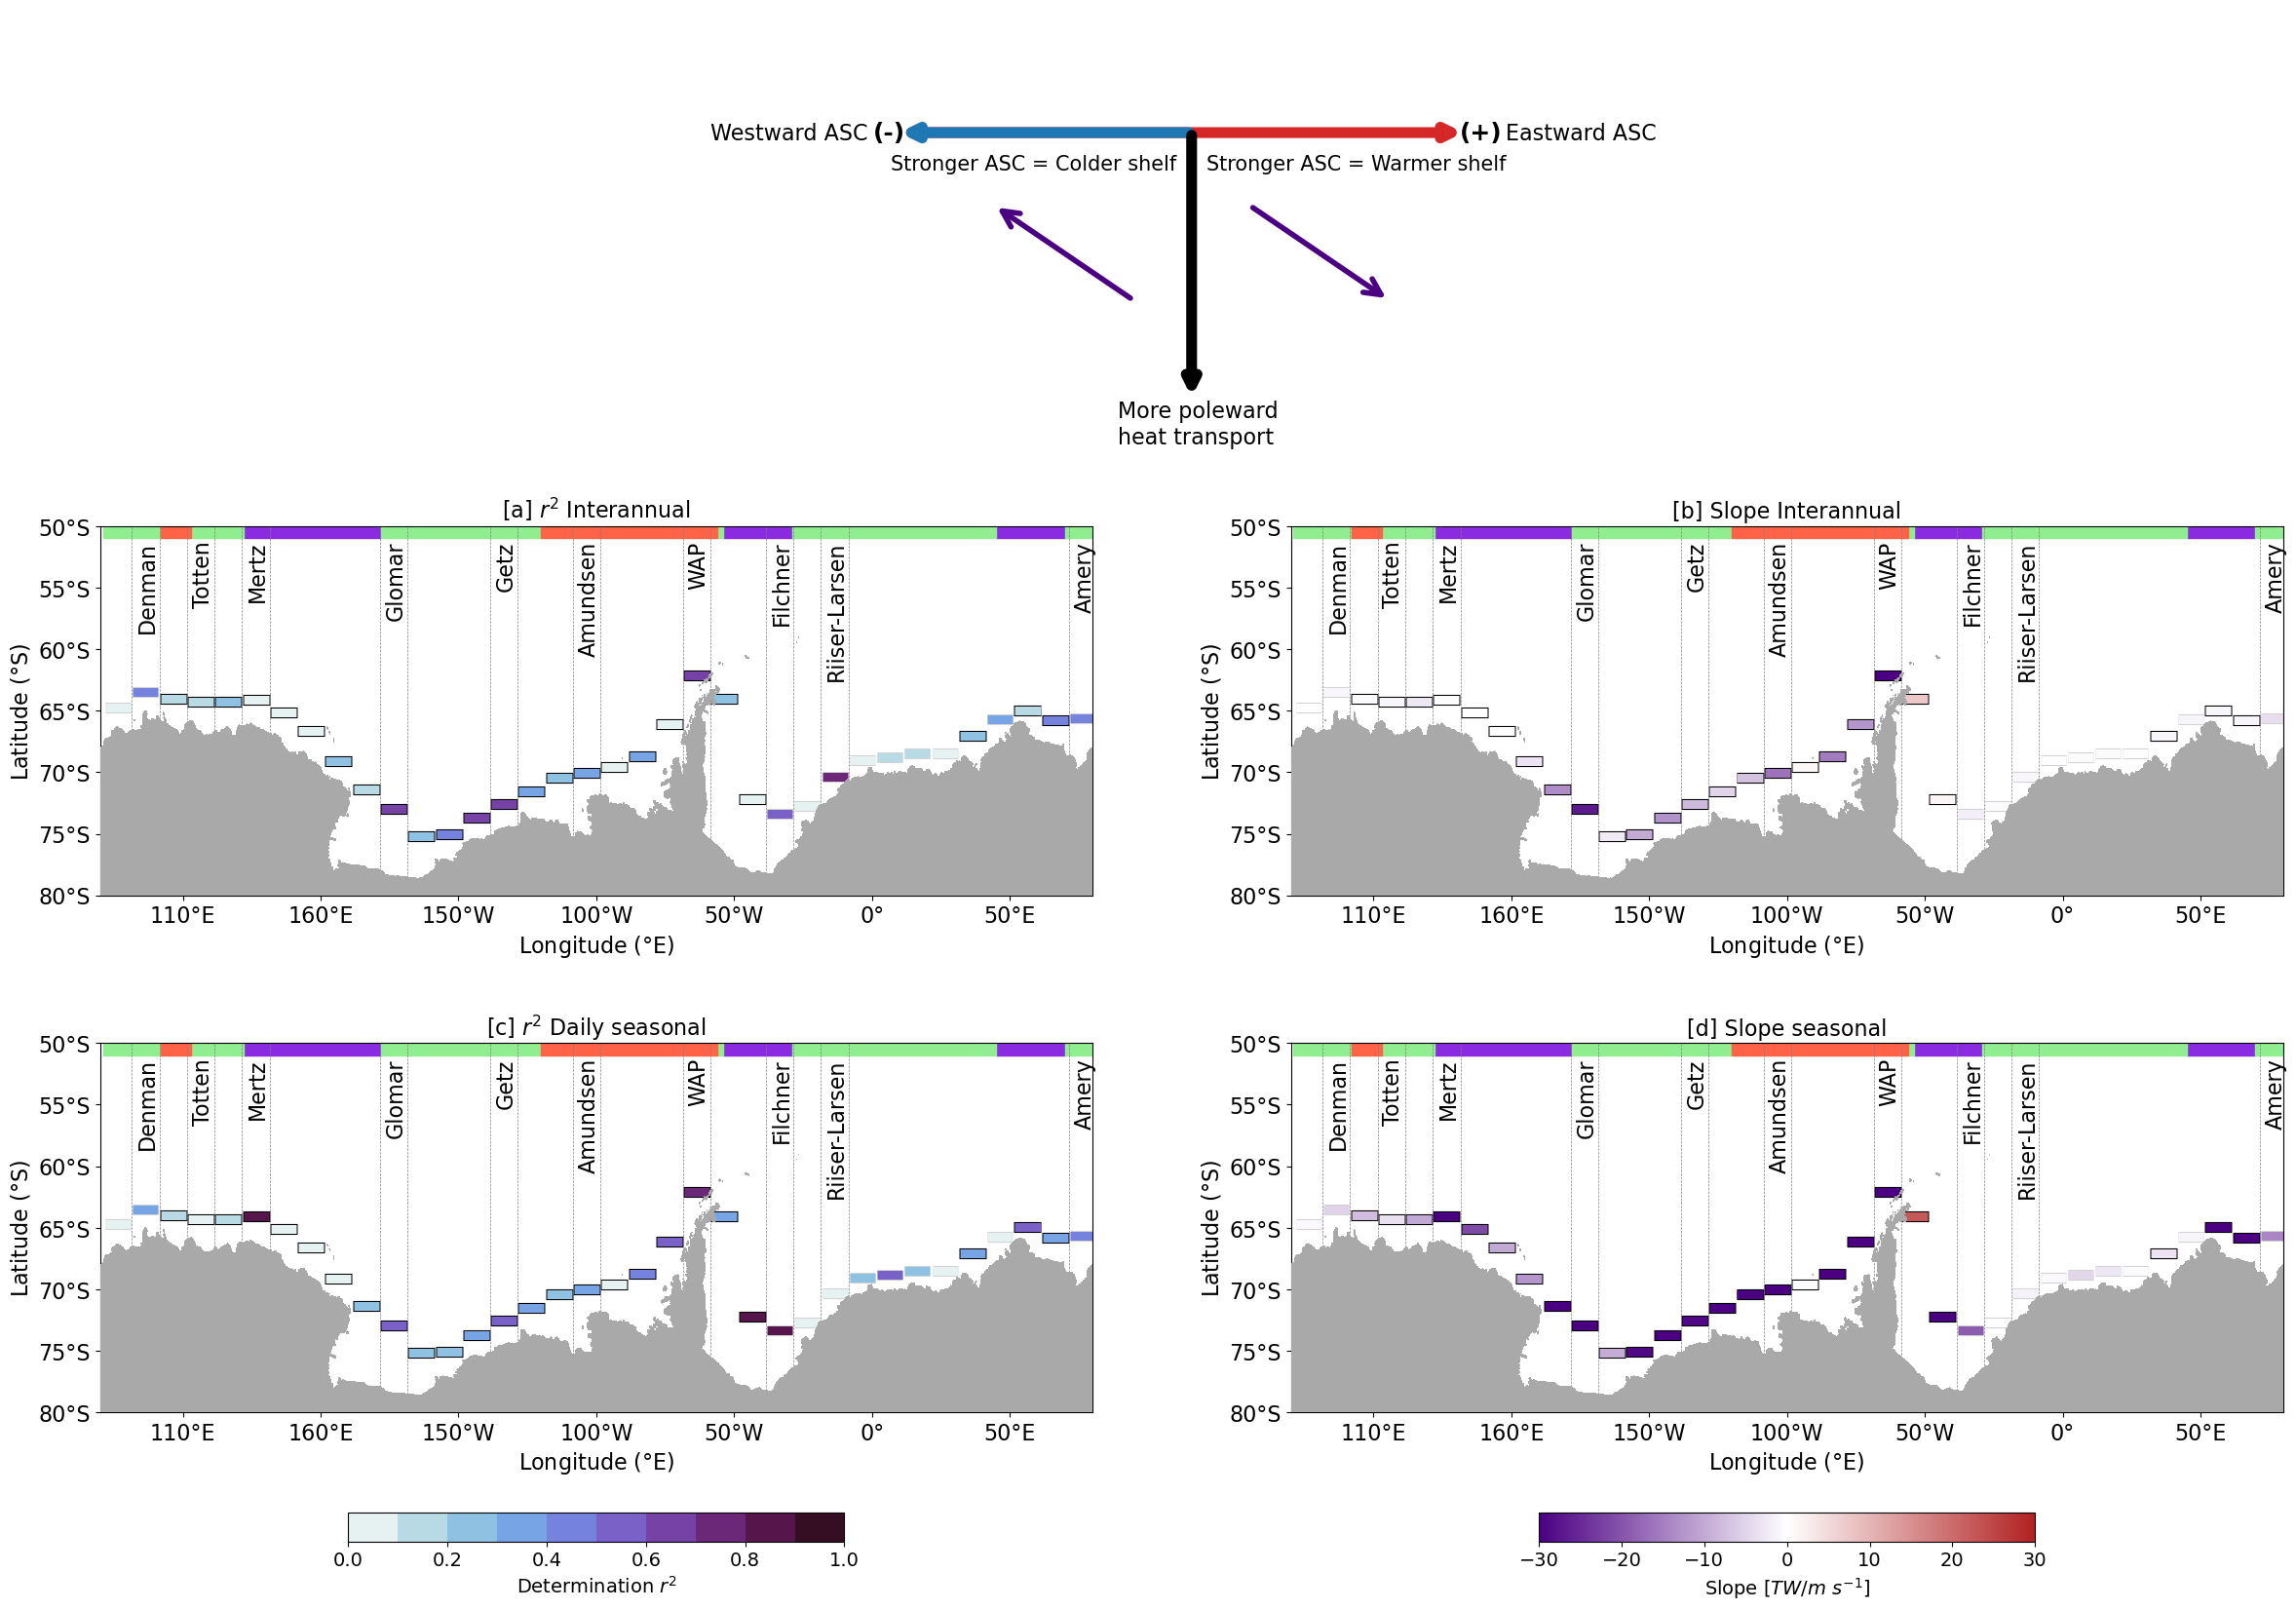

In [103]:
# Plot horizontal lines

fig,ax_cric = plt.subplots(nrows = 3,ncols = 2,figsize = (28, 18))
#ax_cric = fig.add_axes([0,0,0.9,.9])
regime_mask_thickness = [-50.75,-50]
#setting up the norm for normalizing the slope for the colorbar
import matplotlib as mpl
fontsize = 16
timescale_rsq = ['r_sq_annual_10deg','r_sq_daily_10deg','r_sq_all_10deg']
timescale_slope = ['slope_sq_annual_10deg','slope_sq_daily_10deg','slope_sq_all_10deg']



gs = fig.add_gridspec(nrows=3, ncols=1,
                      hspace=0, wspace=0.05)
ax_compass = fig.add_subplot(gs[0, :])
colormap_arrows = custom_curl_cmap()
colormap_toplot = custom_curl_cmap()
norm_arrows = mpl.colors.Normalize(vmin=-30, vmax=30)
# #creating the compass plot     ##############
ax_cric[0,0].remove()
ax_cric[0,1].remove()
left=-10
deltax = 20
ycentre = 1.5e-5 
deltay = 0
xoffset = 10


POS_ASCarrow = FancyArrowPatch((left+0.7, ycentre), (left+deltax-0.7, ycentre+deltay), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='tab:red',
                        edgecolor='tab:red')
NEG_ASCarrow = FancyArrowPatch((-left-xoffset, ycentre), (-left-deltax, ycentre+deltay), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='tab:blue',
                        edgecolor='tab:blue')

HT_ASCarrow = FancyArrowPatch((0, ycentre), (0, ycentre+deltay-0.0004), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='black',
                        edgecolor='black')


slope_Q1 = FancyArrowPatch((-deltax/10, -2e-5-ycentre-0.0002), ((-left-deltax)/1.5, -2e-5-ycentre-0.00006), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=30,  # Size of the arrowhead
                        linewidth=4,
                        facecolor=colormap_toplot(norm_arrows(-78)),
                        edgecolor=colormap_toplot(norm_arrows(-78)))

slope_Q2 = FancyArrowPatch(((left+deltax)/1.5, -2e-5-ycentre-0.0002), (deltax/10, -2e-5-ycentre-0.00006), 
                        arrowstyle='<-', # Basic arrowhead style
                        mutation_scale=30,  # Size of the arrowhead
                        linewidth=4,
                        facecolor=colormap_toplot(norm_arrows(-78)),
                        edgecolor=colormap_toplot(norm_arrows(-78)))

ax_compass.add_patch(POS_ASCarrow)
ax_compass.add_patch(NEG_ASCarrow)
ax_compass.add_patch(HT_ASCarrow)
ax_compass.add_patch(slope_Q1)
ax_compass.add_patch(slope_Q2)

ax_compass.set_ylim(-5e-4,2e-4)
ax_compass.set_xlim(-37,37)
ax_compass.text(left - 0.8 ,.5e-5 ,'(-)', fontsize = 18,fontweight = 'bold')
ax_compass.text(-left - 0.9,.5e-5 ,'(+)', fontsize = 18,fontweight = 'bold')
# ax_compass.text(left*0.8 ,0.4e-4 ,'Westward ASC', fontsize = 16)
# ax_compass.text(left*-0.3 ,0.4e-4 ,'Eastward ASC', fontsize = 16)
ax_compass.text(left - 6.3 ,.5e-5,'Westward ASC', fontsize = 16)
ax_compass.text(-left + 0.65,.5e-5 ,'Eastward ASC', fontsize = 16)


ax_compass.text(left * 1.02,-0.4e-4 ,'Stronger ASC = Colder shelf', fontsize = 15)
ax_compass.text(left*-0.05 ,-0.4e-4 ,'Stronger ASC = Warmer shelf', fontsize = 15)
ax_compass.text(-2.5 , -4.5e-4 ,'More poleward \nheat transport', fontsize = 16, color = 'black')

#removing x and y ticks
ax_compass.spines["top"].set_visible(False)
ax_compass.spines["right"].set_visible(False)
ax_compass.spines["left"].set_visible(False)
ax_compass.spines["bottom"].set_visible(False)
ax_compass.set_yticks(ticks=[])
ax_compass.set_xticks(ticks=[])

#ax_compass.set_title('Correlation''s slope compass',fontsize = 18)


for collumns in range(2):
    for lines in range(2): #range of liness
        #line 0 = annual, line 1 = monthly, line 2: daily climatology
        
        if collumns ==0: 
            varplot = timescale_rsq[lines]; cmap = discrete_cmap(10, cmocean.dense)
            timescale_name = [r'[a] $r^2$ Interannual', r'[c] $r^2$ Daily seasonal', r'[e] $r^2$ Monthly']
            barcolorvar = 'vall' #variable being plotted on the horizontal lines is r2
            cbarlabel = r'Determination $r^2$'
            norm_forplot = [0,1]
            norm = mpl.colors.Normalize(vmin=0, vmax=1)
        elif collumns ==1: 
            varplot = timescale_slope[lines] 
            cmap = custom_curl_cmap()
            timescale_name = [r'[b] Slope Interannual', r'[d] Slope seasonal', r'[f] Slope monthly']
            cbarlabel = r'Slope [$TW/m\ s^{-1}$]'
            norm_forplot = [-30,30]
            barcolorvar = 'vall'
            norm = mpl.colors.Normalize(vmin=-100, vmax=100)
        
        
        
        ax_cric[lines+1,collumns].contourf(hu_transect_og.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=20)
        ax_cric[lines+1,collumns].set_ylim([-80,-50])
        ax_cric[lines+1,collumns].set_ylabel('Latitude ($\degree$S)',fontsize=fontsize)
        ax_cric[lines+1,collumns].set_xlabel('Longitude ($\degree$E)',fontsize=fontsize)
        ax_cric[lines+1,collumns].set_title(timescale_name[lines] ,fontsize=fontsize)
        ax_cric[lines+1,collumns].tick_params(labelsize=fontsize)
        regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
                   'Glomar', 'Amundsen', 'Filchner', \
                   'Riiser-Larsen', 'Amery', 'Denman']
        
        
        for lat, vall, lon in zip(lat_bins_10deg, eval(varplot), r_sq_annual_10deg.lon_bins.values):
            #print(varplot)
            if lines ==1:
                plotlines = ax_cric[lines+1,collumns].scatter(eval(varplot +'.lon_bins'), lat_bins_10deg,s=0, c=eval(varplot),cmap = cmap, vmin=norm_forplot[0],vmax=norm_forplot[1])
            # grey outter contours
            ax_cric[lines+1,collumns].hlines(
                lat,
                lon - 4.6,  # Start of line
                lon + 4.6,  # End of line
                color='lightgrey',  # Map r_sq or slope value to a color
                linewidth=8  # Optional: Set line width
            )
            if volume_percentage.Perc_cells_in_CDW.sel(lon_bins=lon).values>=5:
                #Highlighting the cases of high volume
                ax_cric[lines+1,collumns].hlines(
                    lat,
                    lon - 4.95,  # Start of line
                    lon + 4.95,  # End of line
                    color='black',  # Map r_sq or slope value to a color
                    linewidth=8  # Optional: Set line width
                )
            
            ax_cric[lines+1,collumns].hlines(
                lat,
                lon - 4.6,  # Start of line
                lon + 4.6,  # End of line
                color=cmap(norm(eval(barcolorvar))),  # Map r_sq or slope value to a color
                linewidth=6.5  # Optional: Set line width
            )
        # ax_cric[lines+1,collumns].pcolormesh(lon_along_contour_formask, regime_mask_thickness,ASC_mask_wilma_forplot  , cmap=CustomCmap_no3)
        ## THOMPSON et al 2018 COMPARISON (estimated from Figure 4)
        ## D regions
        ax_cric[lines+1,collumns].fill_between([-29,-54],[-51,-51],[1,1], color = 'blueviolet')
        ax_cric[lines+1,collumns].fill_between([-178,-228],[-51,-51],[1,1], color = 'blueviolet')
        ax_cric[lines+1,collumns].fill_between([70,45],[-51,-51],[1,1], color = 'blueviolet')
        ## F regions
        ax_cric[lines+1,collumns].fill_between([-54,-56],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-120,-178],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-228,-247],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-279,-258],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([70,80],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-29,45],[-51,-51],[1,1], color = 'lightgreen')
        ## W regions
        ax_cric[lines+1,collumns].fill_between([-120,-56],[-51,-51],[1,1], color = 'tomato')
        ax_cric[lines+1,collumns].fill_between([-247,-258],[-51,-51],[1,1], color = 'tomato')
        #ax_critic[lines+1,collumns].axis('off')
        #ax_critic[lines+1,collumns].text(81,0.65, 'Obs', fontsize = 40)
        
        ax_cric[lines+1,collumns].set_xlim(-280,80)
        
        ax_cric[lines+1,collumns].yaxis.set_major_formatter(LatitudeFormatter())
        ax_cric[lines+1,collumns].xaxis.set_major_formatter(LongitudeFormatter())
        if lines ==1:
            cax = ax_cric[lines+1,collumns].inset_axes([0.25, -0.35, 0.5, 0.08])
            cb = plt.colorbar(plotlines,cax=cax, location = 'bottom')
            cb.set_label(label= cbarlabel, fontsize = 14)
            cb.ax.tick_params(labelsize=14)
        
        for i in range(longitude_slices.size):
            ax_cric[lines+1,collumns].vlines(longitude_slices[i]-5, -80, -50, color='grey', linewidth=0.5, linestyle='dashed')
            ax_cric[lines+1,collumns].vlines(longitude_slices[i]+5, -80, -50, color='grey', linewidth=0.5, linestyle='dashed')
            ax_cric[lines+1,collumns].text(longitude_slices[i]+0.75, -51.2, regions_abridged[i], rotation=90,fontsize=fontsize, va='top', ha='center')
            # ax_cric.fill_betweenx(longitude_slices[i]-5, longitude_slices[i]+5)
plt.subplots_adjust(left=0.1, right=0.9, 
                    top=0.9, bottom=0.1, 
                    wspace=0.2, hspace=0.4)

# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Fig3_8May2025.png',dpi=300,bbox_inches='tight')
# plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Fig3_8May2025.pdf',dpi=300,bbox_inches='tight')



In [104]:
#version 2, large tape round percentages lower than 5 %

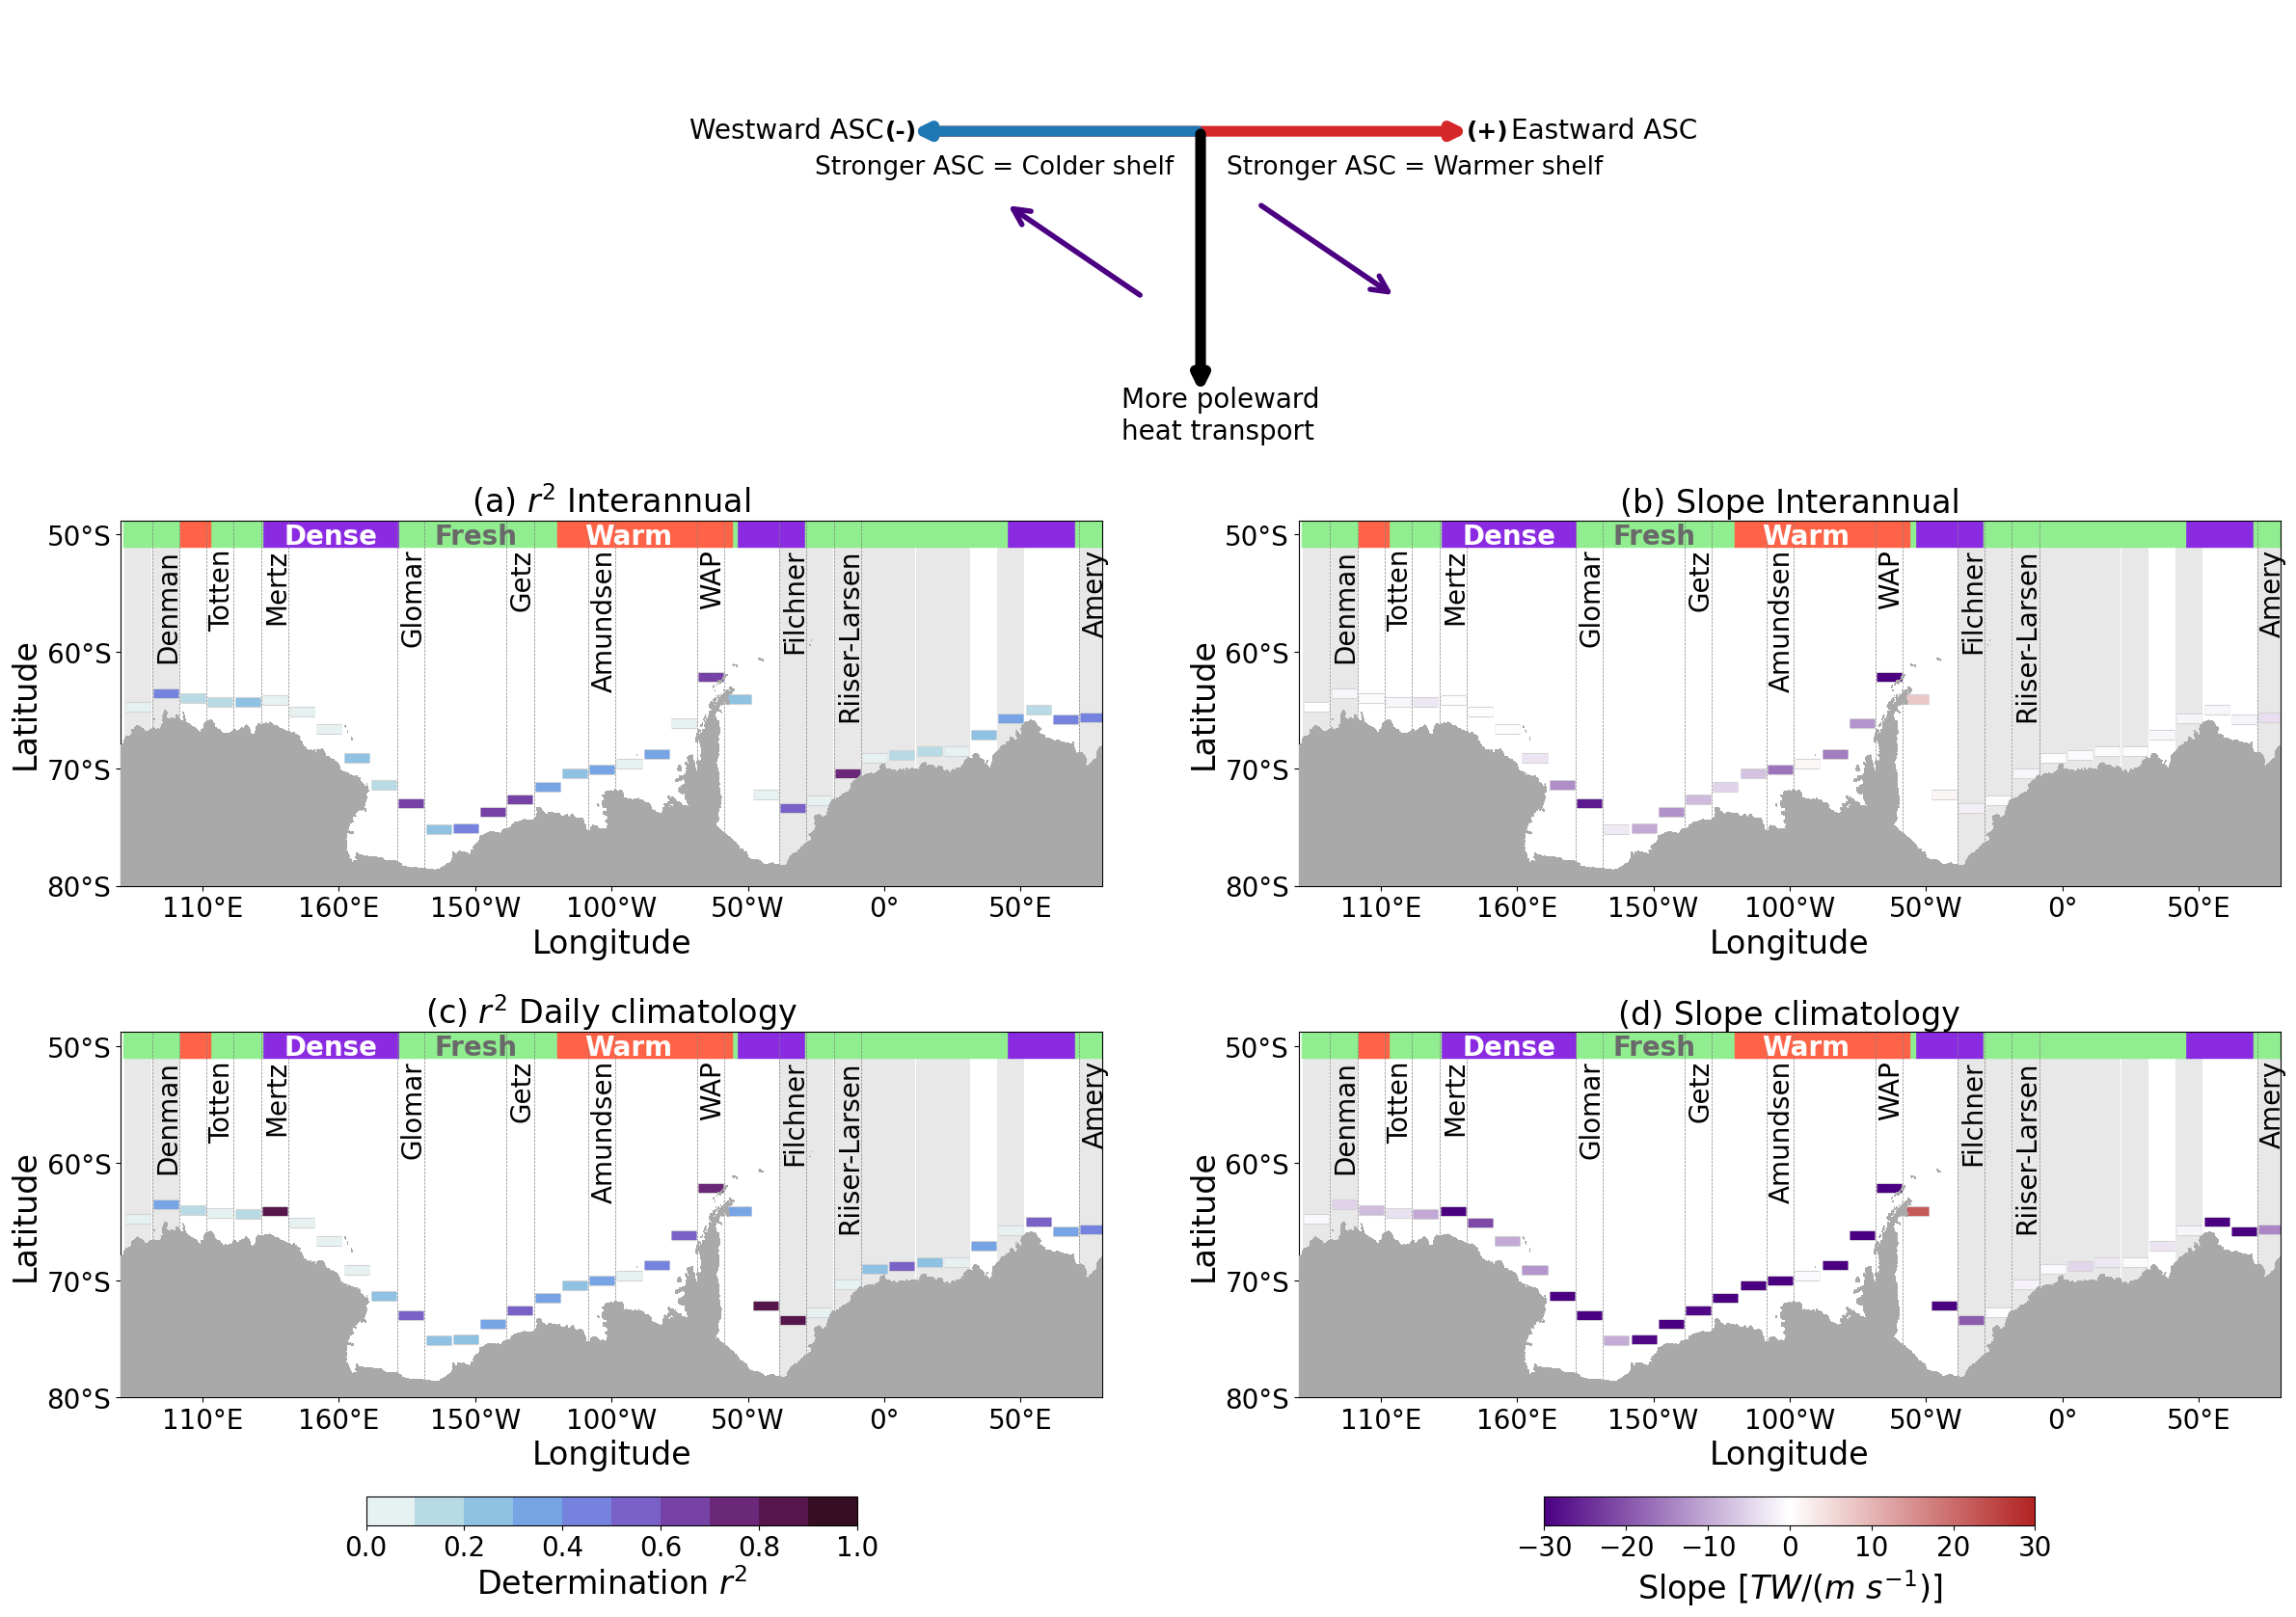

In [105]:
# Plot horizontal lines

fig,ax_cric = plt.subplots(nrows = 3,ncols = 2,figsize = (28, 18)) #28,18
#ax_cric = fig.add_axes([0,0,0.9,.9])
regime_mask_thickness = [-50.75,-48]
#setting up the norm for normalizing the slope for the colorbar
import matplotlib as mpl
fontsize = 24
timescale_rsq = ['r_sq_annual_10deg','r_sq_daily_10deg','r_sq_all_10deg']
timescale_slope = ['slope_sq_annual_10deg','slope_sq_daily_10deg','slope_sq_all_10deg']



gs = fig.add_gridspec(nrows=3, ncols=1,
                      hspace=0, wspace=0.05)
ax_compass = fig.add_subplot(gs[0, :])
colormap_arrows = custom_curl_cmap()
colormap_toplot = custom_curl_cmap()
norm_arrows = mpl.colors.Normalize(vmin=-30, vmax=30)
# #creating the compass plot     ##############
ax_cric[0,0].remove()
ax_cric[0,1].remove()
left=-10
deltax = 20
ycentre = 1.5e-5 
deltay = 0
xoffset = 10


POS_ASCarrow = FancyArrowPatch((left+0.7, ycentre), (left+deltax-0.7, ycentre+deltay), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='tab:red',
                        edgecolor='tab:red')
NEG_ASCarrow = FancyArrowPatch((-left-xoffset, ycentre), (-left-deltax, ycentre+deltay), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='tab:blue',
                        edgecolor='tab:blue')

HT_ASCarrow = FancyArrowPatch((0, ycentre), (0, ycentre+deltay-0.0004), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='black',
                        edgecolor='black')


slope_Q1 = FancyArrowPatch((-deltax/10, -2e-5-ycentre-0.0002), ((-left-deltax)/1.5, -2e-5-ycentre-0.00006), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=30,  # Size of the arrowhead
                        linewidth=4,
                        facecolor=colormap_toplot(norm_arrows(-78)),
                        edgecolor=colormap_toplot(norm_arrows(-78)))

slope_Q2 = FancyArrowPatch(((left+deltax)/1.5, -2e-5-ycentre-0.0002), (deltax/10, -2e-5-ycentre-0.00006), 
                        arrowstyle='<-', # Basic arrowhead style
                        mutation_scale=30,  # Size of the arrowhead
                        linewidth=4,
                        facecolor=colormap_toplot(norm_arrows(-78)),
                        edgecolor=colormap_toplot(norm_arrows(-78)))

ax_compass.add_patch(POS_ASCarrow)
ax_compass.add_patch(NEG_ASCarrow)
ax_compass.add_patch(HT_ASCarrow)
ax_compass.add_patch(slope_Q1)
ax_compass.add_patch(slope_Q2)

ax_compass.set_ylim(-5e-4,2e-4)
ax_compass.set_xlim(-37,37)
ax_compass.text(left - 0.8 ,.5e-5 ,'(-)', fontsize = 18,fontweight = 'bold')
ax_compass.text(-left - 0.9,.5e-5 ,'(+)', fontsize = 18,fontweight = 'bold')
# ax_compass.text(left*0.8 ,0.4e-4 ,'Westward ASC', fontsize = 16)
# ax_compass.text(left*-0.3 ,0.4e-4 ,'Eastward ASC', fontsize = 16)
ax_compass.text(left - 7.5 ,.4e-5,'Westward ASC', fontsize = 20)
ax_compass.text(-left + 0.65,.5e-5 ,'Eastward ASC', fontsize = 20)


ax_compass.text(left * 1.32,-0.5e-4 ,'Stronger ASC = Colder shelf', fontsize = 19)
ax_compass.text(left*-0.09 ,-0.5e-4 ,'Stronger ASC = Warmer shelf', fontsize = 19)
ax_compass.text(-2.7 , -4.5e-4 ,'More poleward \nheat transport', fontsize = 20, color = 'black')

#removing x and y ticks
ax_compass.spines["top"].set_visible(False)
ax_compass.spines["right"].set_visible(False)
ax_compass.spines["left"].set_visible(False)
ax_compass.spines["bottom"].set_visible(False)
ax_compass.set_yticks(ticks=[])
ax_compass.set_xticks(ticks=[])

#ax_compass.set_title('Correlation''s slope compass',fontsize = 18)


for collumns in range(2):
    for lines in range(2): #range of liness
        #line 0 = annual, line 1 = monthly, line 2: daily climatology
        
        if collumns ==0: 
            varplot = timescale_rsq[lines]; cmap = discrete_cmap(10, cmocean.dense)
            timescale_name = [r'(a) $r^2$ Interannual', r'(c) $r^2$ Daily climatology', r'(e) $r^2$ Monthly']
            barcolorvar = 'vall' #variable being plotted on the horizontal lines is r2
            cbarlabel = r'Determination $r^2$'
            norm_forplot = [0,1]
            norm = mpl.colors.Normalize(vmin=0, vmax=1)
        elif collumns ==1: 
            varplot = timescale_slope[lines] 
            cmap = custom_curl_cmap()
            timescale_name = [r'(b) Slope Interannual', r'(d) Slope climatology', r'(f) Slope monthly']
            cbarlabel = r'Slope [$TW/(m\ s^{-1})$]'
            norm_forplot = [-30,30]
            barcolorvar = 'vall'
            norm = mpl.colors.Normalize(vmin=-100, vmax=100)
        
        
        
        ax_cric[lines+1,collumns].contourf(hu_transect_og.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=20)
        ax_cric[lines+1,collumns].set_ylim([-80,-48.8])# it was -50
        ax_cric[lines+1,collumns].set_ylabel('Latitude',fontsize=fontsize)
        ax_cric[lines+1,collumns].set_xlabel('Longitude',fontsize=fontsize)
        ax_cric[lines+1,collumns].set_title(timescale_name[lines] ,fontsize=fontsize)
        ax_cric[lines+1,collumns].tick_params(labelsize=fontsize-4)
        regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
                   'Glomar', 'Amundsen', 'Filchner', \
                   'Riiser-Larsen', 'Amery', 'Denman']
        
        
        for lat, vall, lon in zip(lat_bins_10deg, eval(varplot), r_sq_annual_10deg.lon_bins.values):
            #print(varplot)
            if lines ==1:
                plotlines = ax_cric[lines+1,collumns].scatter(eval(varplot +'.lon_bins'), lat_bins_10deg,s=0, c=eval(varplot),cmap = cmap, vmin=norm_forplot[0],vmax=norm_forplot[1])
            # grey outter contours
            ax_cric[lines+1,collumns].hlines(
                lat,
                lon - 4.6,  # Start of line
                lon + 4.6,  # End of line
                color='lightgrey',  # Map r_sq or slope value to a color
                linewidth=8  # Optional: Set line width
            )
            if volume_percentage.Perc_cells_in_CDW.sel(lon_bins=lon).values<=5:
                #Highlighting the cases of high volume
                ax_cric[lines+1,collumns].hlines(
                    lat,
                    lon - 4.95,  # Start of line
                    lon + 4.95,  # End of line
                    color=(0.91, 0.91, 0.91),  # Map r_sq or slope value to a color
                    linewidth=500,zorder=0  # Optional: Set line width
                )
            
            ax_cric[lines+1,collumns].hlines(
                lat,
                lon - 4.6,  # Start of line
                lon + 4.6,  # End of line
                color=cmap(norm(eval(barcolorvar))),  # Map r_sq or slope value to a color
                linewidth=6.5  # Optional: Set line width
            )
        # ax_cric[lines+1,collumns].pcolormesh(lon_along_contour_formask, regime_mask_thickness,ASC_mask_wilma_forplot  , cmap=CustomCmap_no3)
        ## THOMPSON et al 2018 COMPARISON (estimated from Figure 4)
        ## D regions
        ax_cric[lines+1,collumns].fill_between([-29,-54],[-51,-51],[1,1], color = 'blueviolet')
        ax_cric[lines+1,collumns].fill_between([-178,-228],[-51,-51],[1,1], color = 'blueviolet')
        ax_cric[lines+1,collumns].fill_between([70,45],[-51,-51],[1,1], color = 'blueviolet')
        ax_cric[lines+1,collumns].text(-220,-50.8,'Dense',fontsize=20, fontweight='bold',color='white')
        ## F regions
        ax_cric[lines+1,collumns].fill_between([-54,-56],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-120,-178],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-228,-247],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-279,-258],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([70,80],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-29,45],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].text(-165,-50.8,'Fresh',fontsize=20, fontweight='bold',color='dimgrey')
        ## W regions
        ax_cric[lines+1,collumns].fill_between([-120,-56],[-51,-51],[1,1], color = 'tomato')
        ax_cric[lines+1,collumns].fill_between([-247,-258],[-51,-51],[1,1], color = 'tomato')
        ax_cric[lines+1,collumns].text(-110,-50.8,'Warm',fontsize=20, fontweight='bold',color='white')
        
        ax_cric[lines+1,collumns].set_xlim(-280,80)
        
        ax_cric[lines+1,collumns].yaxis.set_major_formatter(LatitudeFormatter())
        ax_cric[lines+1,collumns].xaxis.set_major_formatter(LongitudeFormatter())
        if lines ==1:
            cax = ax_cric[lines+1,collumns].inset_axes([0.25, -0.35, 0.5, 0.08])
            cb = plt.colorbar(plotlines,cax=cax, location = 'bottom')
            cb.set_label(label= cbarlabel, fontsize = 24)
            cb.ax.tick_params(labelsize=20)
        
        for i in range(longitude_slices.size):
            ax_cric[lines+1,collumns].vlines(longitude_slices[i]-5, -80, -48, color='grey', linewidth=0.5, linestyle='dashed')
            ax_cric[lines+1,collumns].vlines(longitude_slices[i]+5, -80, -48, color='grey', linewidth=0.5, linestyle='dashed')
            ax_cric[lines+1,collumns].text(longitude_slices[i]+0.75, -51.2, regions_abridged[i], rotation=90,fontsize=fontsize-4, va='top', ha='center')
            # ax_cric.fill_betweenx(longitude_slices[i]-5, longitude_slices[i]+5)
plt.subplots_adjust(left=0.1, right=0.9, 
                    top=0.9, bottom=0.1, 
                    wspace=0.2, hspace=0.4)

plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Fig3_27AUG2025.png',dpi=300,bbox_inches='tight')
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Fig3_27AUG2025.pdf',dpi=300,bbox_inches='tight')



# plots using correlation coefficient

In [60]:
#calcualting corrlelation coefficient
r_annual_10deg = r_sq_annual_10deg**0.5
r_daily_10deg = r_sq_daily_10deg**0.5
r_all_10deg= r_sq_all_10deg**0.5

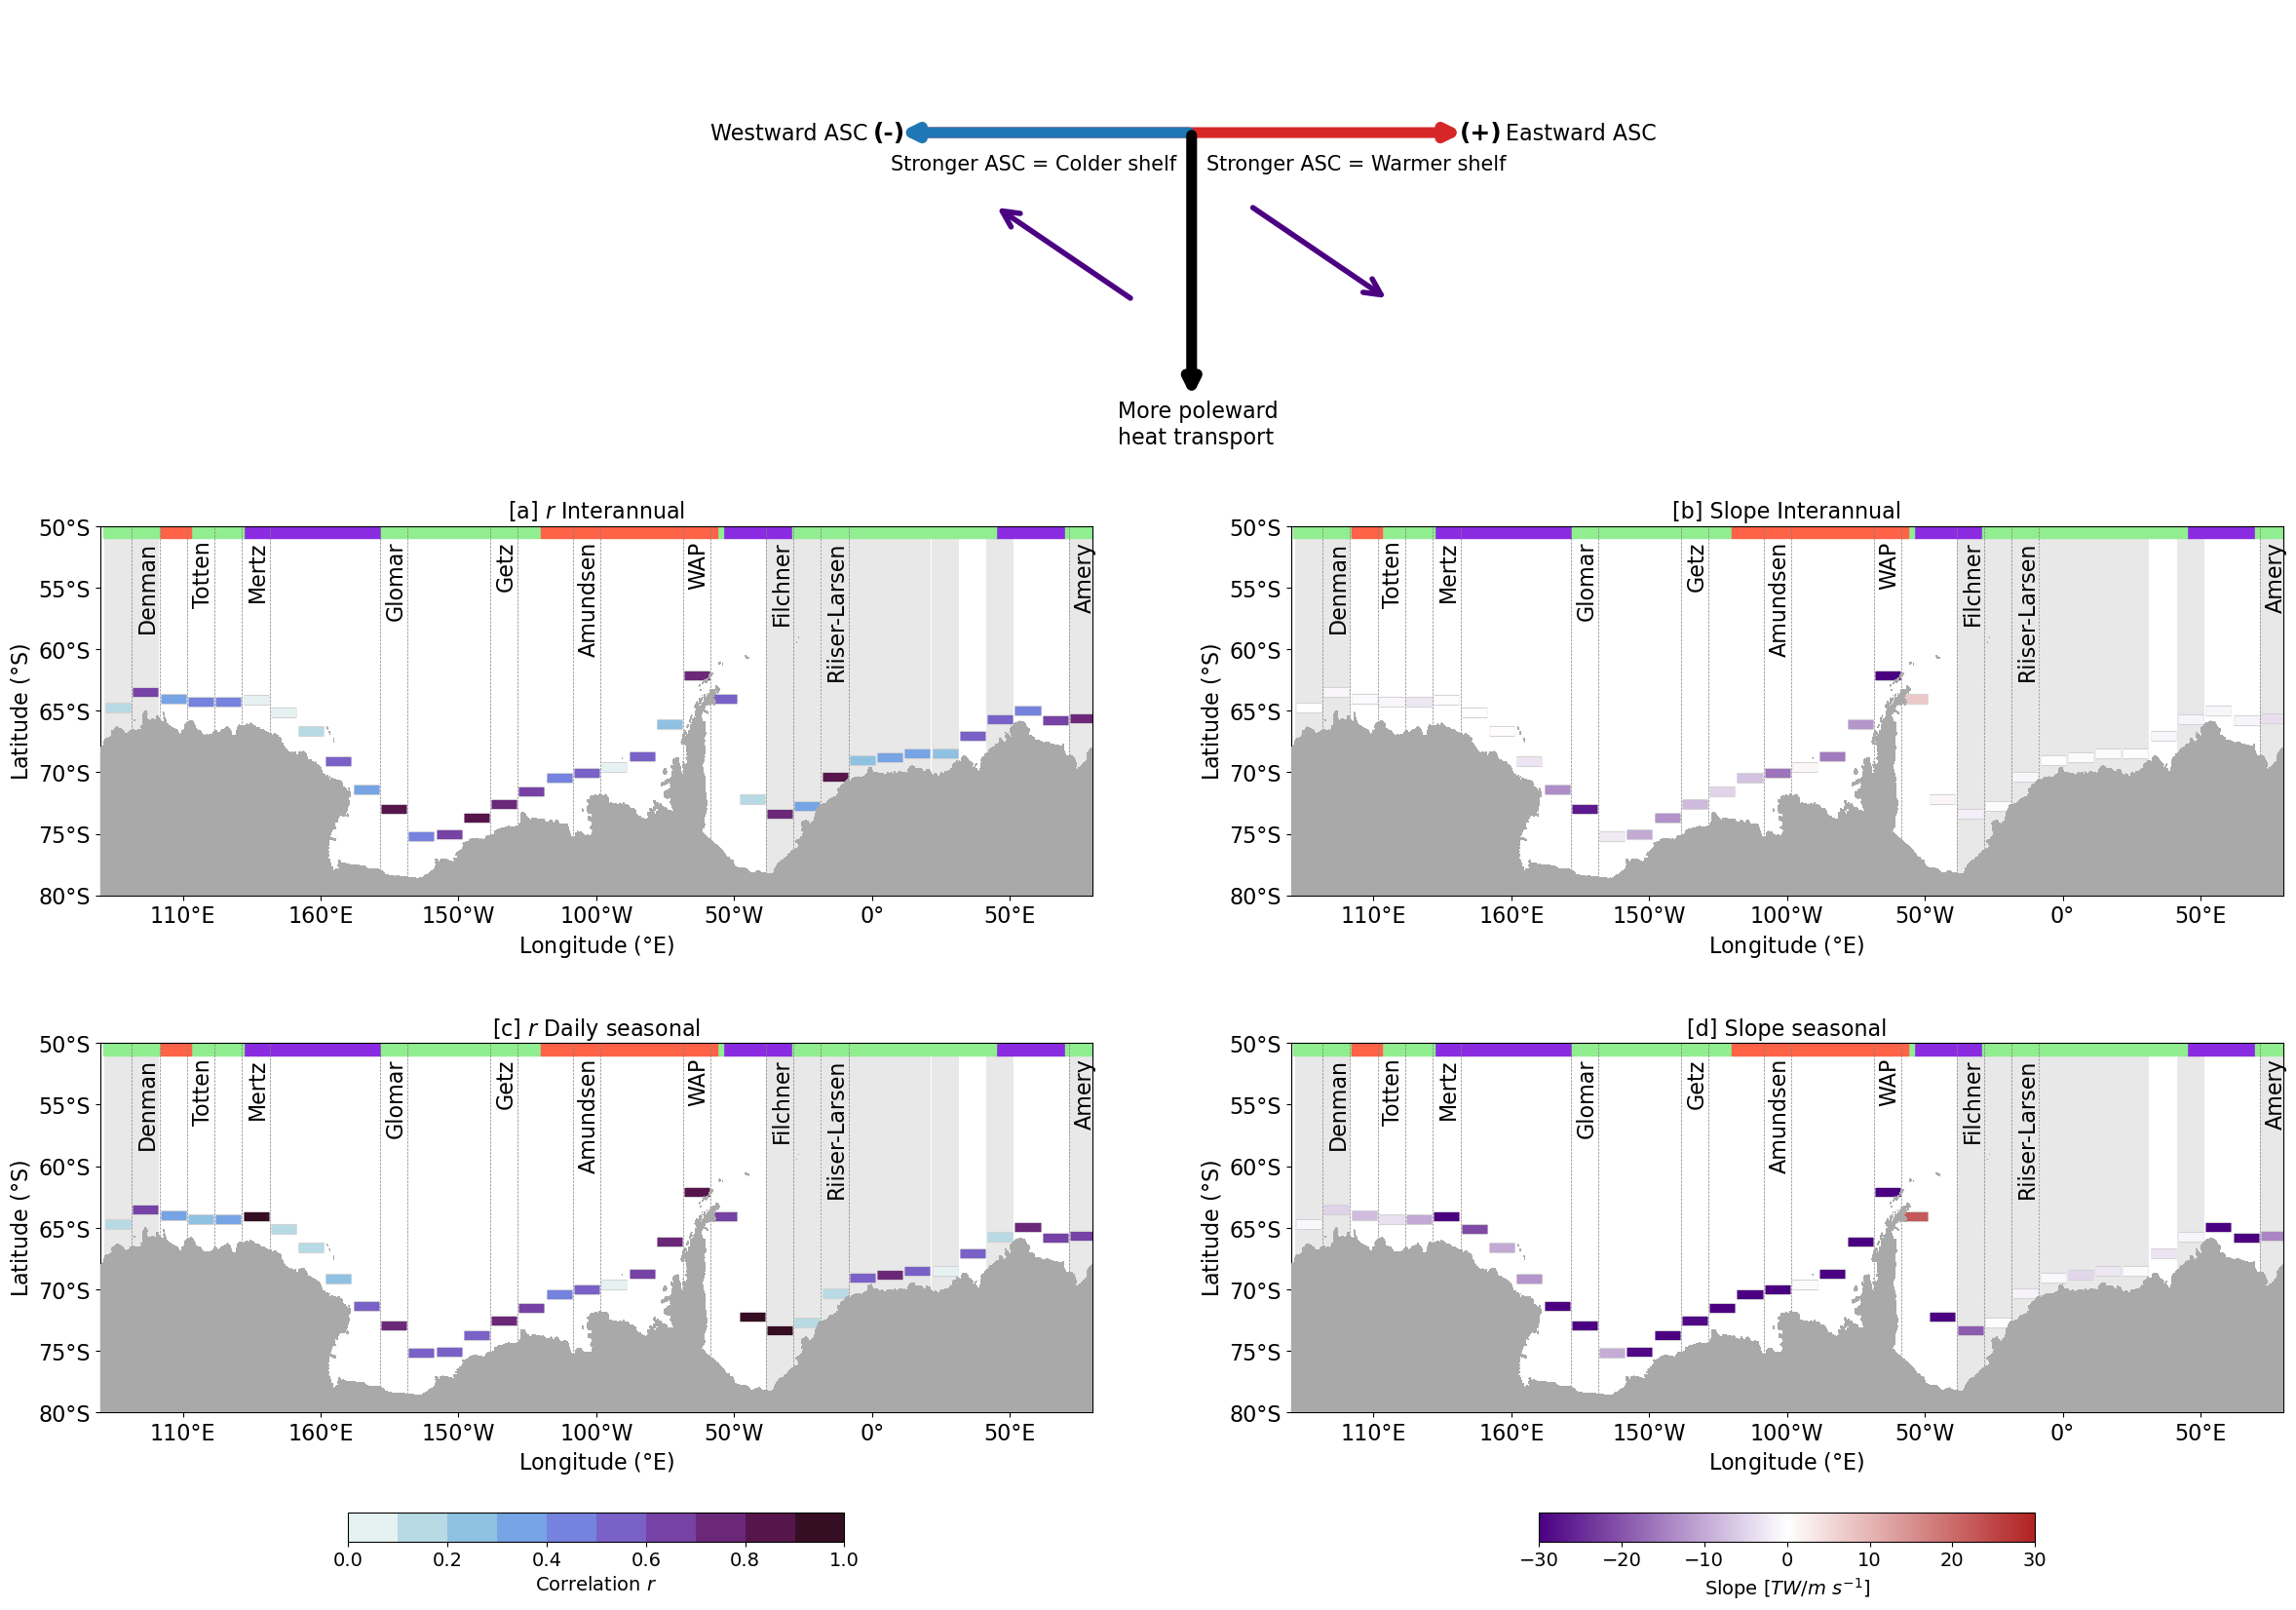

In [62]:

fig,ax_cric = plt.subplots(nrows = 3,ncols = 2,figsize = (28, 18))
#ax_cric = fig.add_axes([0,0,0.9,.9])
regime_mask_thickness = [-50.75,-50]
#setting up the norm for normalizing the slope for the colorbar
import matplotlib as mpl
fontsize = 16
timescale_rsq = ['r_annual_10deg','r_daily_10deg','r_all_10deg']
timescale_slope = ['slope_sq_annual_10deg','slope_sq_daily_10deg','slope_sq_all_10deg']



gs = fig.add_gridspec(nrows=3, ncols=1,
                      hspace=0, wspace=0.05)
ax_compass = fig.add_subplot(gs[0, :])
colormap_arrows = custom_curl_cmap()
colormap_toplot = custom_curl_cmap()
norm_arrows = mpl.colors.Normalize(vmin=-30, vmax=30)
# #creating the compass plot     ##############
ax_cric[0,0].remove()
ax_cric[0,1].remove()
left=-10
deltax = 20
ycentre = 1.5e-5 
deltay = 0
xoffset = 10


POS_ASCarrow = FancyArrowPatch((left+0.7, ycentre), (left+deltax-0.7, ycentre+deltay), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='tab:red',
                        edgecolor='tab:red')
NEG_ASCarrow = FancyArrowPatch((-left-xoffset, ycentre), (-left-deltax, ycentre+deltay), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='tab:blue',
                        edgecolor='tab:blue')

HT_ASCarrow = FancyArrowPatch((0, ycentre), (0, ycentre+deltay-0.0004), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=20,  # Size of the arrowhead
                        linewidth=8,
                        facecolor='black',
                        edgecolor='black')


slope_Q1 = FancyArrowPatch((-deltax/10, -2e-5-ycentre-0.0002), ((-left-deltax)/1.5, -2e-5-ycentre-0.00006), 
                        arrowstyle='->', # Basic arrowhead style
                        mutation_scale=30,  # Size of the arrowhead
                        linewidth=4,
                        facecolor=colormap_toplot(norm_arrows(-78)),
                        edgecolor=colormap_toplot(norm_arrows(-78)))

slope_Q2 = FancyArrowPatch(((left+deltax)/1.5, -2e-5-ycentre-0.0002), (deltax/10, -2e-5-ycentre-0.00006), 
                        arrowstyle='<-', # Basic arrowhead style
                        mutation_scale=30,  # Size of the arrowhead
                        linewidth=4,
                        facecolor=colormap_toplot(norm_arrows(-78)),
                        edgecolor=colormap_toplot(norm_arrows(-78)))

ax_compass.add_patch(POS_ASCarrow)
ax_compass.add_patch(NEG_ASCarrow)
ax_compass.add_patch(HT_ASCarrow)
ax_compass.add_patch(slope_Q1)
ax_compass.add_patch(slope_Q2)

ax_compass.set_ylim(-5e-4,2e-4)
ax_compass.set_xlim(-37,37)
ax_compass.text(left - 0.8 ,.5e-5 ,'(-)', fontsize = 18,fontweight = 'bold')
ax_compass.text(-left - 0.9,.5e-5 ,'(+)', fontsize = 18,fontweight = 'bold')
# ax_compass.text(left*0.8 ,0.4e-4 ,'Westward ASC', fontsize = 16)
# ax_compass.text(left*-0.3 ,0.4e-4 ,'Eastward ASC', fontsize = 16)
ax_compass.text(left - 6.3 ,.5e-5,'Westward ASC', fontsize = 16)
ax_compass.text(-left + 0.65,.5e-5 ,'Eastward ASC', fontsize = 16)


ax_compass.text(left * 1.02,-0.4e-4 ,'Stronger ASC = Colder shelf', fontsize = 15)
ax_compass.text(left*-0.05 ,-0.4e-4 ,'Stronger ASC = Warmer shelf', fontsize = 15)
ax_compass.text(-2.5 , -4.5e-4 ,'More poleward \nheat transport', fontsize = 16, color = 'black')

#removing x and y ticks
ax_compass.spines["top"].set_visible(False)
ax_compass.spines["right"].set_visible(False)
ax_compass.spines["left"].set_visible(False)
ax_compass.spines["bottom"].set_visible(False)
ax_compass.set_yticks(ticks=[])
ax_compass.set_xticks(ticks=[])

#ax_compass.set_title('Correlation''s slope compass',fontsize = 18)


for collumns in range(2):
    for lines in range(2): #range of liness
        #line 0 = annual, line 1 = monthly, line 2: daily climatology
        
        if collumns ==0: 
            varplot = timescale_rsq[lines]; cmap = discrete_cmap(10, cmocean.dense)
            timescale_name = [r'[a] $r$ Interannual', r'[c] $r$ Daily seasonal', r'[e] $r$ Monthly']
            barcolorvar = 'vall' #variable being plotted on the horizontal lines is r2
            cbarlabel = r'Correlation $r$'
            norm_forplot = [0,1]
            norm = mpl.colors.Normalize(vmin=0, vmax=1)
        elif collumns ==1: 
            varplot = timescale_slope[lines] 
            cmap = custom_curl_cmap()
            timescale_name = [r'[b] Slope Interannual', r'[d] Slope seasonal', r'[f] Slope monthly']
            cbarlabel = r'Slope [$TW/m\ s^{-1}$]'
            norm_forplot = [-30,30]
            barcolorvar = 'vall'
            norm = mpl.colors.Normalize(vmin=-100, vmax=100)
        
        
        
        ax_cric[lines+1,collumns].contourf(hu_transect_og.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=20)
        ax_cric[lines+1,collumns].set_ylim([-80,-50])
        ax_cric[lines+1,collumns].set_ylabel('Latitude ($\degree$S)',fontsize=fontsize)
        ax_cric[lines+1,collumns].set_xlabel('Longitude ($\degree$E)',fontsize=fontsize)
        ax_cric[lines+1,collumns].set_title(timescale_name[lines] ,fontsize=fontsize)
        ax_cric[lines+1,collumns].tick_params(labelsize=fontsize)
        regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
                   'Glomar', 'Amundsen', 'Filchner', \
                   'Riiser-Larsen', 'Amery', 'Denman']
        
        
        for lat, vall, lon in zip(lat_bins_10deg, eval(varplot), r_sq_annual_10deg.lon_bins.values):
            #print(varplot)
            if lines ==1:
                plotlines = ax_cric[lines+1,collumns].scatter(eval(varplot +'.lon_bins'), lat_bins_10deg,s=0, c=eval(varplot),cmap = cmap, vmin=norm_forplot[0],vmax=norm_forplot[1])
            # grey outter contours
            ax_cric[lines+1,collumns].hlines(
                lat,
                lon - 4.6,  # Start of line
                lon + 4.6,  # End of line
                color='lightgrey',  # Map r_sq or slope value to a color
                linewidth=8  # Optional: Set line width
            )
            if volume_percentage.Perc_cells_in_CDW.sel(lon_bins=lon).values<=5:
                #Highlighting the cases of high volume
                ax_cric[lines+1,collumns].hlines(
                    lat,
                    lon - 4.95,  # Start of line
                    lon + 4.95,  # End of line
                    color=(0.91, 0.91, 0.91),  # Map r_sq or slope value to a color
                    linewidth=500,zorder=0  # Optional: Set line width
                )
            
            ax_cric[lines+1,collumns].hlines(
                lat,
                lon - 4.6,  # Start of line
                lon + 4.6,  # End of line
                color=cmap(norm(eval(barcolorvar))),  # Map r_sq or slope value to a color
                linewidth=6.5  # Optional: Set line width
            )
        # ax_cric[lines+1,collumns].pcolormesh(lon_along_contour_formask, regime_mask_thickness,ASC_mask_wilma_forplot  , cmap=CustomCmap_no3)
        ## THOMPSON et al 2018 COMPARISON (estimated from Figure 4)
        ## D regions
        ax_cric[lines+1,collumns].fill_between([-29,-54],[-51,-51],[1,1], color = 'blueviolet')
        ax_cric[lines+1,collumns].fill_between([-178,-228],[-51,-51],[1,1], color = 'blueviolet')
        ax_cric[lines+1,collumns].fill_between([70,45],[-51,-51],[1,1], color = 'blueviolet')
        ## F regions
        ax_cric[lines+1,collumns].fill_between([-54,-56],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-120,-178],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-228,-247],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-279,-258],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([70,80],[-51,-51],[1,1], color = 'lightgreen')
        ax_cric[lines+1,collumns].fill_between([-29,45],[-51,-51],[1,1], color = 'lightgreen')
        ## W regions
        ax_cric[lines+1,collumns].fill_between([-120,-56],[-51,-51],[1,1], color = 'tomato')
        ax_cric[lines+1,collumns].fill_between([-247,-258],[-51,-51],[1,1], color = 'tomato')
        #ax_critic[lines+1,collumns].axis('off')
        #ax_critic[lines+1,collumns].text(81,0.65, 'Obs', fontsize = 40)
        
        ax_cric[lines+1,collumns].set_xlim(-280,80)
        
        ax_cric[lines+1,collumns].yaxis.set_major_formatter(LatitudeFormatter())
        ax_cric[lines+1,collumns].xaxis.set_major_formatter(LongitudeFormatter())
        if lines ==1:
            cax = ax_cric[lines+1,collumns].inset_axes([0.25, -0.35, 0.5, 0.08])
            cb = plt.colorbar(plotlines,cax=cax, location = 'bottom')
            cb.set_label(label= cbarlabel, fontsize = 14)
            cb.ax.tick_params(labelsize=14)
        
        for i in range(longitude_slices.size):
            ax_cric[lines+1,collumns].vlines(longitude_slices[i]-5, -80, -50, color='grey', linewidth=0.5, linestyle='dashed')
            ax_cric[lines+1,collumns].vlines(longitude_slices[i]+5, -80, -50, color='grey', linewidth=0.5, linestyle='dashed')
            ax_cric[lines+1,collumns].text(longitude_slices[i]+0.75, -51.2, regions_abridged[i], rotation=90,fontsize=fontsize, va='top', ha='center')
            # ax_cric.fill_betweenx(longitude_slices[i]-5, longitude_slices[i]+5)
plt.subplots_adjust(left=0.1, right=0.9, 
                    top=0.9, bottom=0.1, 
                    wspace=0.2, hspace=0.4)

plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/FigS4_Correlations.png',dpi=300,bbox_inches='tight')
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/FigS4_Correlations.pdf',dpi=300,bbox_inches='tight')

